In [1]:
import numpy as np 
import torch
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [33]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/'


In [138]:
def get_index(train_batches,shuffle_batches=True, seed=42):
    if shuffle_batches:
        np.random.seed(seed)
        indexes = np.random.randint(0, train_batches, train_batches)
        return iter(indexes)
    else:
        return iter(range(train_batches))
def get_batch(data, index, shuffle_stocks=True, extra_dim=False):
    batch = data[index, :, :].copy()
    batch = np.transpose(batch)
    if shuffle_stocks:
        batch = batch[:, np.random.permutation(batch.shape[1])]
    if extra_dim:
        batch = np.expand_dims(batch, axis=1)
    return batch

    
def plot_training(losses):
    fig, axes = plt.subplots(1,len(losses), sharex=False, sharey=False)
    for i , (key, value) in enumerate(losses.items()):
        x_points = range(0, len(value))
        axes[i].set_title(key, fontsize=10)
        axes[i].plot(x_points, value, color="blue", linewidth=5)
        axes[i].yaxis.grid(True, zorder=0)
        axes[i].set_xlabel('Iteration', fontsize=10)
        # axes[i].legend(loc='upper right')
    # plt.tight_layout()
    plt.show()
    
def train_vq_vae(vq_vae, data, epochs=20, shuffle_stocks=True,shuffle_batches=True,extra_dim=False,learning_rate=0.0001 ):
    train_batches = data.shape[0] 
    opt = torch.optim.Adam(vq_vae.parameters(), lr=learning_rate)
    train_res_recon_error = []
    train_vq_loss = []
    loss_total_to_plot = []
    perplexity_to_plot = []

    for epoch in range(epochs):
        vq_vae.train()
        indexes = get_index(train_batches,shuffle_batches)
        recon_error_total = 0
        vq_loss_total = 0
        loss_total = 0
        perplexity_total = 0
        for i in range(train_batches):
            index = next(indexes)
            batch= get_batch(data, index, shuffle_stocks=shuffle_stocks ,extra_dim=extra_dim)
            x = torch.from_numpy(batch) # GPU
            # print(x.shape)
            opt.zero_grad()
            x_recon, vq_loss, perplexity, encodings, encoding_indices, quantized  = vq_vae(x)
            recon_error = F.mse_loss(x_recon, x)
            loss = recon_error + vq_loss
            # loss = 0.7*((x - x_hat)**2).sum() + 0.3*vautoencoder.encoder.kl
            loss.backward()
            opt.step()
            recon_error_total += recon_error.item()
            vq_loss_total += vq_loss.item()
            loss_total += loss.item()
            perplexity_total += perplexity.item()

        train_res_recon_error.append(recon_error_total/train_batches)
        train_vq_loss.append(vq_loss_total/train_batches)
        loss_total_to_plot.append(loss_total/train_batches)
        perplexity_to_plot.append(perplexity_total/train_batches)
        print('Epoch %s/%s, Loss=%s, recon_error=%s, vq_loss: %s' % (epoch+1, epochs, loss_total/train_batches, recon_error_total/train_batches, vq_loss_total/train_batches))    

    losses={'Total loss':loss_total_to_plot,
            'Reconstruction loss':train_res_recon_error,
            'VQ loss': train_vq_loss, 
            }
    plot_training(losses)

    return vq_vae


def plot_reconstruction(batch_idx, series_idx, model, data, extra_dim=False):
    batch= data[batch_idx]
    batch= np.transpose(batch)
    x = torch.from_numpy(batch)
    model.eval()
    if extra_dim:
        x = x.view( x.size(0), 1, x.size(1))
    # print(x.shape)
    x_hat, _, _, _, _, _ = model(x.to(device))
    # x_hat = vae.decoder(z)
    # x_hat = x_hat.numpy()
    x_hat = x_hat.to('cpu').detach().numpy()
    # print(x_hat.shape)
    if extra_dim:
        x_hat = np.squeeze(x_hat, 1)
    # print(x_hat.shape)

    fig, axes = plt.subplots(3,1, figsize=(30,20), dpi= 50)
    axes[0].plot(batch[series_idx, :], label='original')
    axes[0].plot(x_hat[series_idx, :], label='reconstructed')
    axes[0].legend()
    axes[1].plot(x_hat[series_idx, :], label='reconstructed', color='darkorange')
    axes[1].legend()
    axes[2].plot(batch[series_idx, :], label='original')
    axes[2].legend()
    plt.show()
    return x_hat 


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 1, input.size(1))

class pre_vq_vae(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1))
        return x
class post_vq_vae(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), x.size(2))
        return x

class PrintLayer(nn.Module):
    def __init__(self, name=None):
        super(PrintLayer, self).__init__()
        self.name = name
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(self.name)
        # print(x)
        print(x.shape)
        return x 


def get_encode_indices(model, data, extra_dim=False):
    train_batches = data.shape[0]
    batch_size = data.shape[2]
    encoding_indices_data = []
    for index in range(train_batches):
        model.eval()
        batch= get_batch(data, index, shuffle_stocks=False ,extra_dim=extra_dim)
        # print(batch.shape)
        x = torch.from_numpy(batch)
        # print(x.shape)
        x_recon, loss, perplexity, encodings, encoding_indices, quantized  = model(x)
        encoding_indices = encoding_indices.cpu().detach().numpy()
        # print(encoding_indices.shape)
        encoding_indices_data.append(encoding_indices)
    
    encoding_indices_data = np.array(encoding_indices_data)
    shape = encoding_indices_data.shape
    encoding_indices_data = encoding_indices_data.reshape(shape[0]*shape[1],shape[2])
    encoding_indices_data = pd.DataFrame(encoding_indices_data)

    columns_names =['e'+ str(i) for i in range(encoding_indices_data.shape[1])]
    encoding_indices_data.columns = columns_names
    # print('encoding_indices_data', encoding_indices_data.shape)
    return encoding_indices_data
    
def sampling_to_quantize(encoding_indices_data, stocks):
    columns_names = encoding_indices_data.columns
    encoding_sampled = []
    for j in range(stocks):
        start =  encoding_indices_data['e0'].value_counts(normalize=True)
        draw = np.random.choice(start.index, 1, p=start.values)
        draw = draw[0]
        encoding = [draw]
        for i in range(1,encoding_indices_data.shape[1]):
            colum = columns_names[i-1]
            # print(colum)
            colum_next = columns_names[i]
            # print(colum_next)
            sample = encoding_indices_data[encoding_indices_data[colum]==draw][colum_next].value_counts(normalize=True)
            # print(sample)
            draw = np.random.choice(sample.index, 1, p=sample.values)
            draw = draw[0]
            # print(draw)
            encoding.append(draw)
        encoding_sampled.append(encoding)
    encoding_sampled = np.array(encoding_sampled)
    # print('encoding sampled', encoding_sampled.shape)
    encoding_sampled = torch.from_numpy(encoding_sampled).double()
    encoding_sampled = encoding_sampled.view(encoding_sampled.size(0), encoding_sampled.size(1), 1)
    encoding_sampled = encoding_sampled.to(torch.int64)
    # print('encoding sampled', encoding_sampled.shape)
    return encoding_sampled

def quantize_encodings(encoding_sampled, model,embedding_dim, num_embeddings):
    input_shape = encoding_sampled.shape
    flat_encoding = encoding_sampled.view(-1, 1)
    encodings = torch.zeros(flat_encoding.shape[0], num_embeddings).double()
    encodings.scatter_(1, flat_encoding, 1)
    embedding = model._vq_vae._embedding 
    quantized = torch.matmul(encodings, embedding.weight).view([input_shape[0],input_shape[1],embedding_dim])
    quantized=quantized.permute(0, 2, 1).contiguous()
    x_gen = model.decoder(quantized)
    x_gen_np = x_gen if type(x_gen) is np.ndarray else x_gen.detach().numpy()
    # print('x_gen_np', x_gen_np.shape)
    return x_gen_np


def vqvae_generation(model, data, embedding_dim, num_embeddings, extra_dim=False):
    stocks = data.shape[2]
    encoding_indices_data = get_encode_indices(model, data.copy(), extra_dim=extra_dim)
    encoding_sampled = sampling_to_quantize(encoding_indices_data, stocks)
    x_gen = quantize_encodings(encoding_sampled, model, embedding_dim, num_embeddings)
    if extra_dim:
        x_gen = np.squeeze(x_gen, 1)
    return x_gen

# def plot_series(series_np, num_series=5):
#     i=1
#     for  x_sample in series_np:
#         plt.plot(x_sample)
#         plt.show()
#         plt.pause(0.1)
#         i += 1
#         if i > num_series:
#             break

def plot_series(batch, idxs:list, label, title=None, figsize=(15, 5), merge=False):
    # fig, ax = plt.subplots(1, len(idxs), figsize=figsize)
    for i, idx in enumerate(idxs):
        plt.plot(batch[idx], label=label+str(i))
        plt.legend()
        if title:
            plt.suptitle(title)
        plt.show()
    if merge:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        for i, idx in enumerate(idxs):
            ax.plot(batch[idx], label=label+str(i))
            ax.legend()
        if title:
            fig.suptitle(title)
            plt.show()   

In [3]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


## Vector Quantization layer


In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).double()
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        # print('input shape: ', inputs.shape)
        inputs = inputs.permute(0, 2, 1).contiguous()
        # print('input shape BCL -> BLC: ', inputs.shape)
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        # print('flat input shape: ', flat_input.shape)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        # print('encoding_indices shape: ', encoding_indices.shape)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device).double()
        encodings.scatter_(1, encoding_indices, 1)
        # print('encodings shape: ', encodings.shape)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        # print('quantized shape: ', quantized.shape)
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BLC -> BCL
        encoding_indices=encoding_indices.view(input_shape[0], input_shape[1])
        # print('encoding_indices shape: ', encoding_indices.shape)
        # encoding_indices=encoding_indices.permute(0, 2, 1).contiguous()
        # print('encoding_indices shape BLC -> BCL: ', encoding_indices.shape)
        quantized=quantized.permute(0, 2, 1).contiguous()
        # print('quantized shape BLC -> BCL: ', quantized.shape)
        encodings = encodings.view(input_shape[0], input_shape[1], self._num_embeddings)
        # print('encodings shape: ', encodings.shape)        
        return loss, quantized, perplexity, encodings, encoding_indices
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).double()
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim)).double()
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device).double()
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings


# VQ-VAE Fully Dense

    encoder input
    torch.Size([434, 256])
    dense 1
    torch.Size([434, 128])
    dense 2
    torch.Size([434, 64])
    pre_vq_vae
    torch.Size([434, 1, 64])
    input shape:  torch.Size([434, 1, 64])
    input shape BCL -> BLC:  torch.Size([434, 64, 1])
    flat input shape:  torch.Size([27776, 1])
    encoding_indices shape:  torch.Size([27776, 1])
    encodings shape:  torch.Size([27776, 128])
    quantized shape:  torch.Size([434, 64, 1])
    encoding_indices shape:  torch.Size([434, 64])
    encoding_indices shape BLC -> BCL:  torch.Size([434, 64])
    quantized shape BLC -> BCL:  torch.Size([434, 1, 64])
    encodings shape:  torch.Size([434, 64, 128])
    decoder input
    torch.Size([434, 1, 64])
    post_vq_vae
    torch.Size([434, 64])
    dense 3
    torch.Size([434, 128])
    dense 4
    torch.Size([434, 256])  

In [5]:
class VQ_VAE_Dense(nn.Module):
    def __init__(self,num_hiddens=64,
                 num_embeddings=300, embedding_dim=1, commitment_cost=0.25, decay=0, **kwargs ):
        super(VQ_VAE_Dense, self).__init__(**kwargs )
        self.encoder = nn.Sequential(
            # PrintLayer(name='encoder input'),
            nn.Linear(256, 128).double(),
            # PrintLayer(name='dense 1'),
            nn.ReLU(),
            nn.Linear(128, num_hiddens).double(),
            # PrintLayer(name='dense 2'),
            pre_vq_vae(),
            # PrintLayer(name='pre_vq_vae')

        )
          
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)

        
        self.decoder = nn.Sequential(
            # PrintLayer(name='decoder input'),
            post_vq_vae(),
            # PrintLayer(name='post_vq_vae'),
            nn.Linear(num_hiddens, 128).double(),
            # PrintLayer(name='dense 3'),
            nn.ReLU(),
            nn.Linear(128, 256).double(),
            # PrintLayer(name='dense 4'),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        loss, quantized, perplexity, encodings, encoding_indices = self._vq_vae(z)
        x_recon = self.decoder(quantized)
        return x_recon, loss, perplexity, encodings, encoding_indices, quantized 


In [47]:



num_hiddens = 64


embedding_dim = 1
num_embeddings = 256

commitment_cost = 0.25 # beta 0.25 of the paper [0.1, 2]

decay = 0

learning_rate = 1e-3

In [21]:
vq_vae_dense = VQ_VAE_Dense(num_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

Epoch 1/100, Loss=0.0008706612554784124, recon_error=0.0005721984295677211, vq_loss: 0.0002984628259106919
Epoch 2/100, Loss=0.000309036097520605, recon_error=0.000308812687120377, vq_loss: 2.2341040022810045e-07
Epoch 3/100, Loss=0.00030262063679483575, recon_error=0.0003023287672971177, vq_loss: 2.9186949771792655e-07
Epoch 4/100, Loss=0.0002943851730829018, recon_error=0.0002933232731450033, vq_loss: 1.061899937898487e-06
Epoch 5/100, Loss=0.00028503591862323076, recon_error=0.0002828929821920305, vq_loss: 2.1429364312003482e-06
Epoch 6/100, Loss=0.0002760709474315927, recon_error=0.000272873843648404, vq_loss: 3.1971037831887064e-06
Epoch 7/100, Loss=0.0002683096344614361, recon_error=0.0002644126356140275, vq_loss: 3.896998847408792e-06
Epoch 8/100, Loss=0.0002625777819087337, recon_error=0.00025829625733043884, vq_loss: 4.28152457829472e-06
Epoch 9/100, Loss=0.0002567664839884849, recon_error=0.00025409791176431634, vq_loss: 2.668572224168794e-06
Epoch 10/100, Loss=0.000250096258

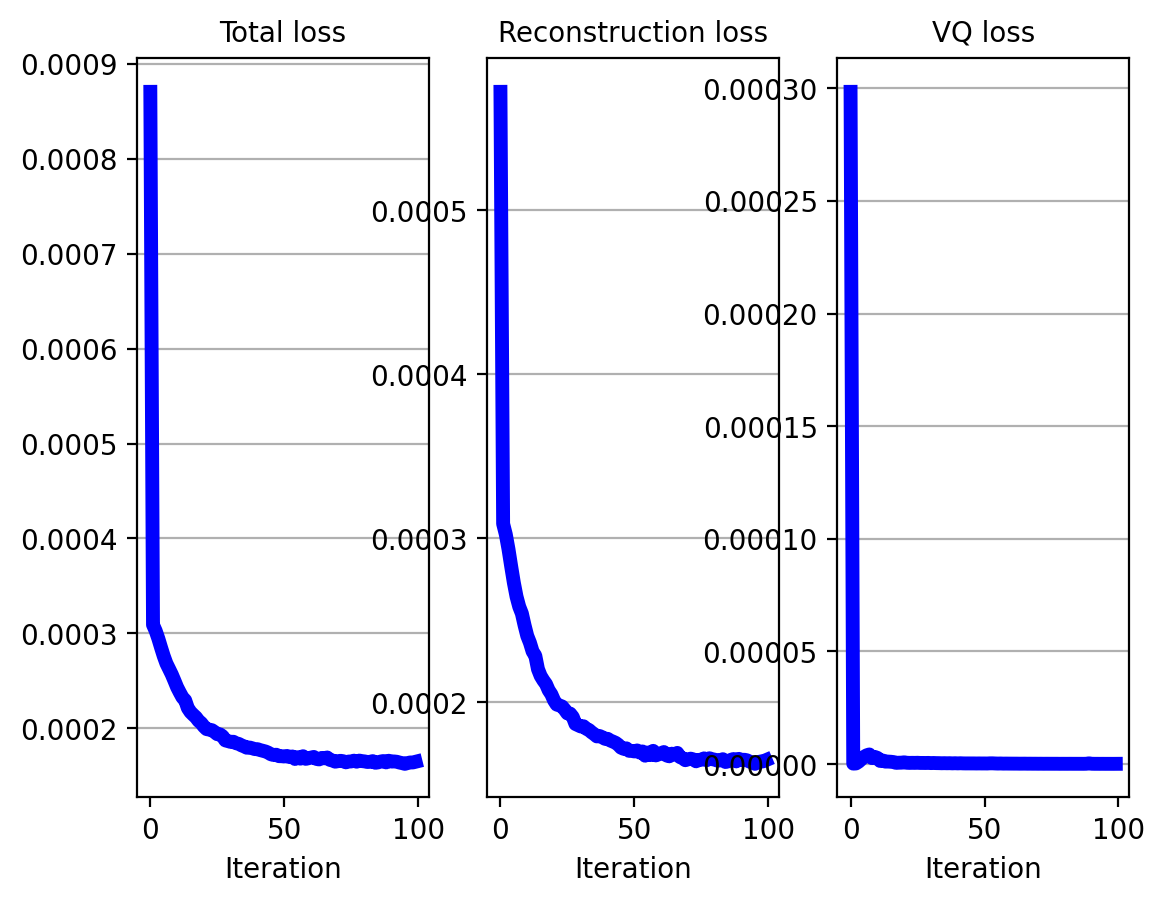

In [22]:
vq_vae_dense = train_vq_vae(vq_vae_dense, data, epochs=100, learning_rate=learning_rate)

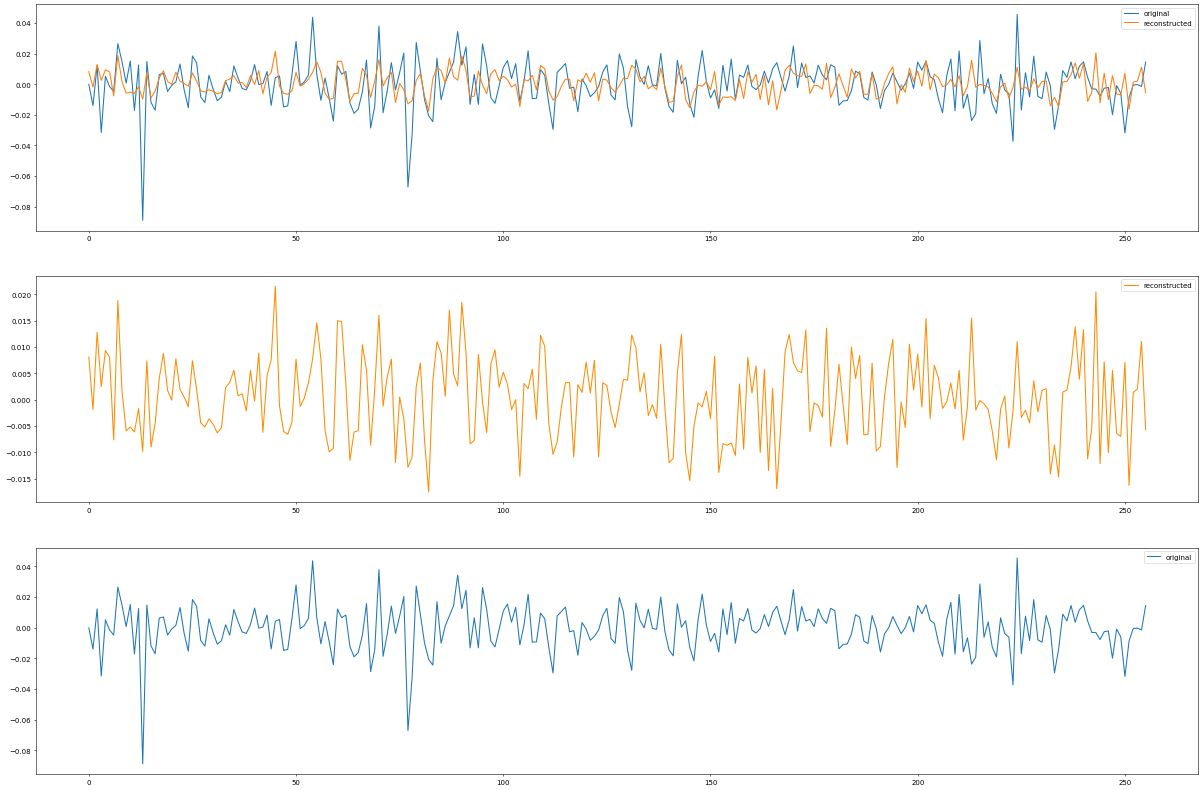

In [23]:
batch_idx = 0
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_dense, data, extra_dim=False)

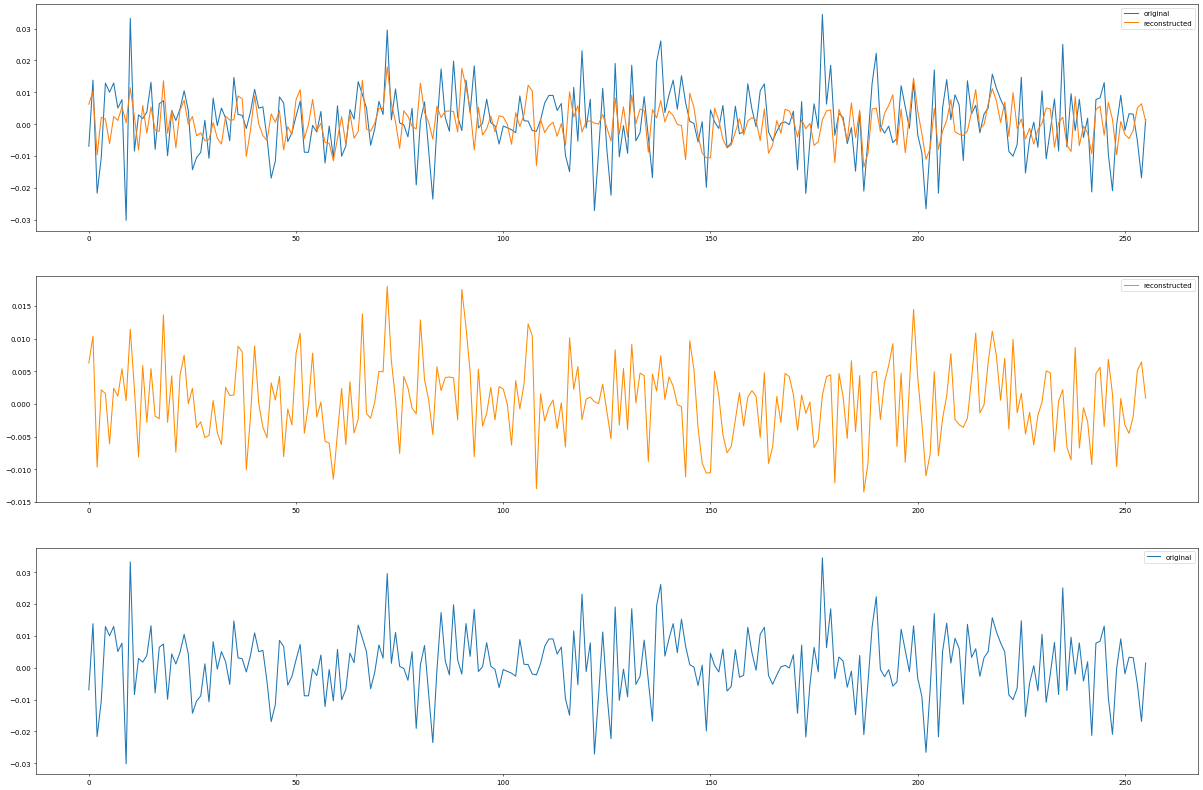

In [24]:
batch_idx = 40
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_dense, data, extra_dim=False)

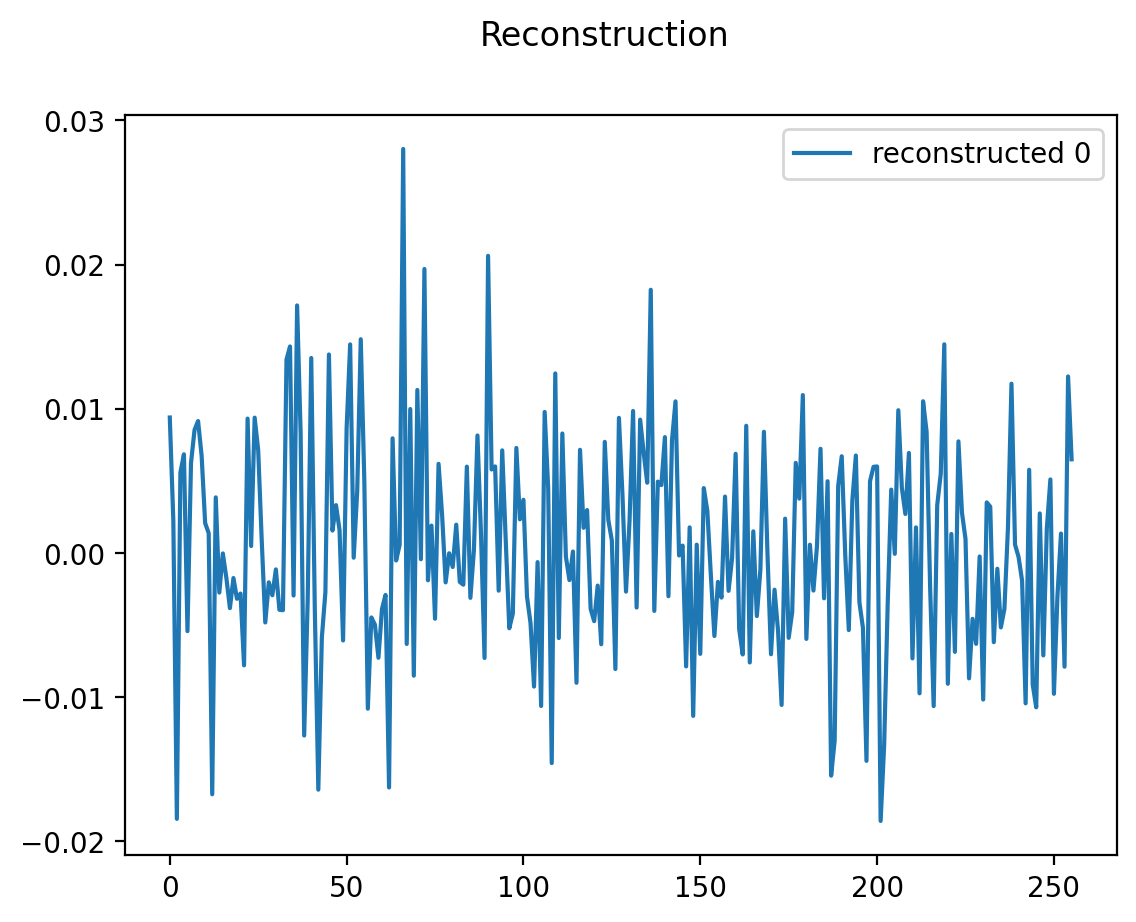

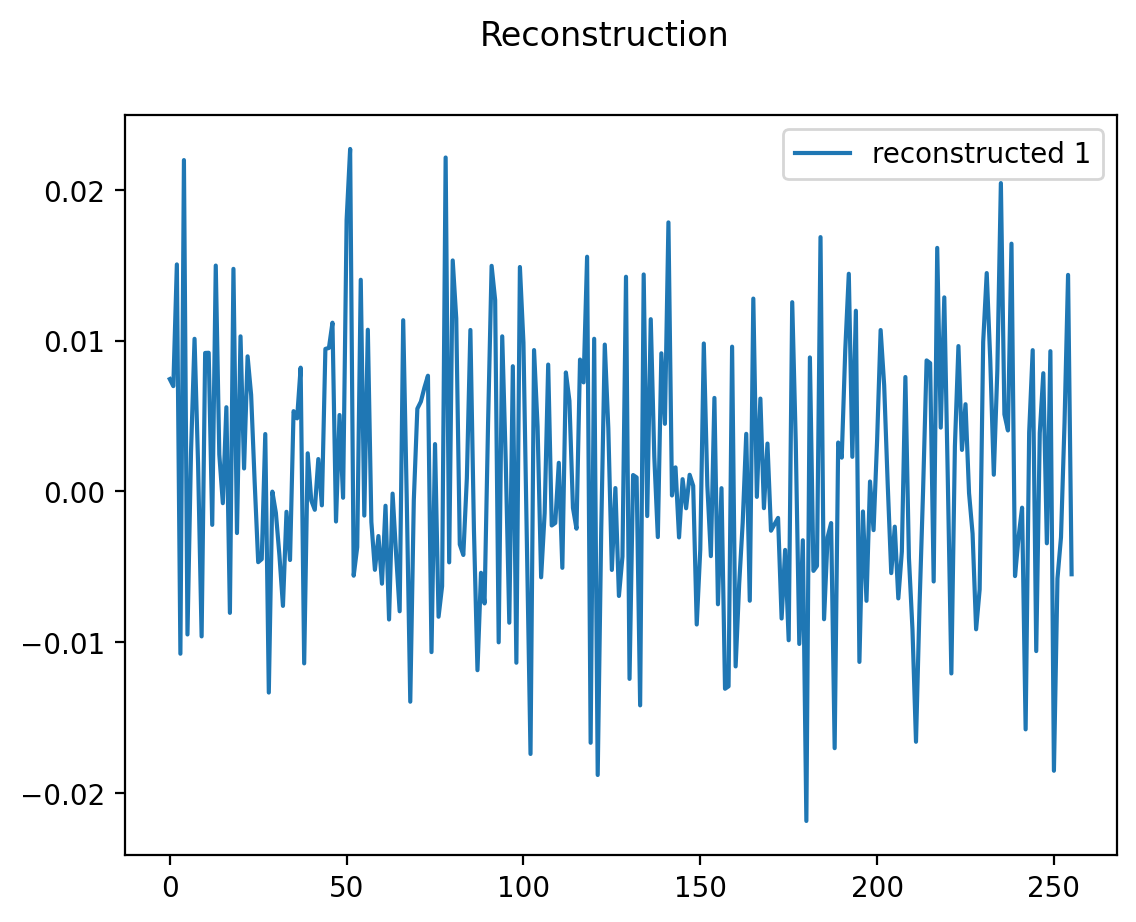

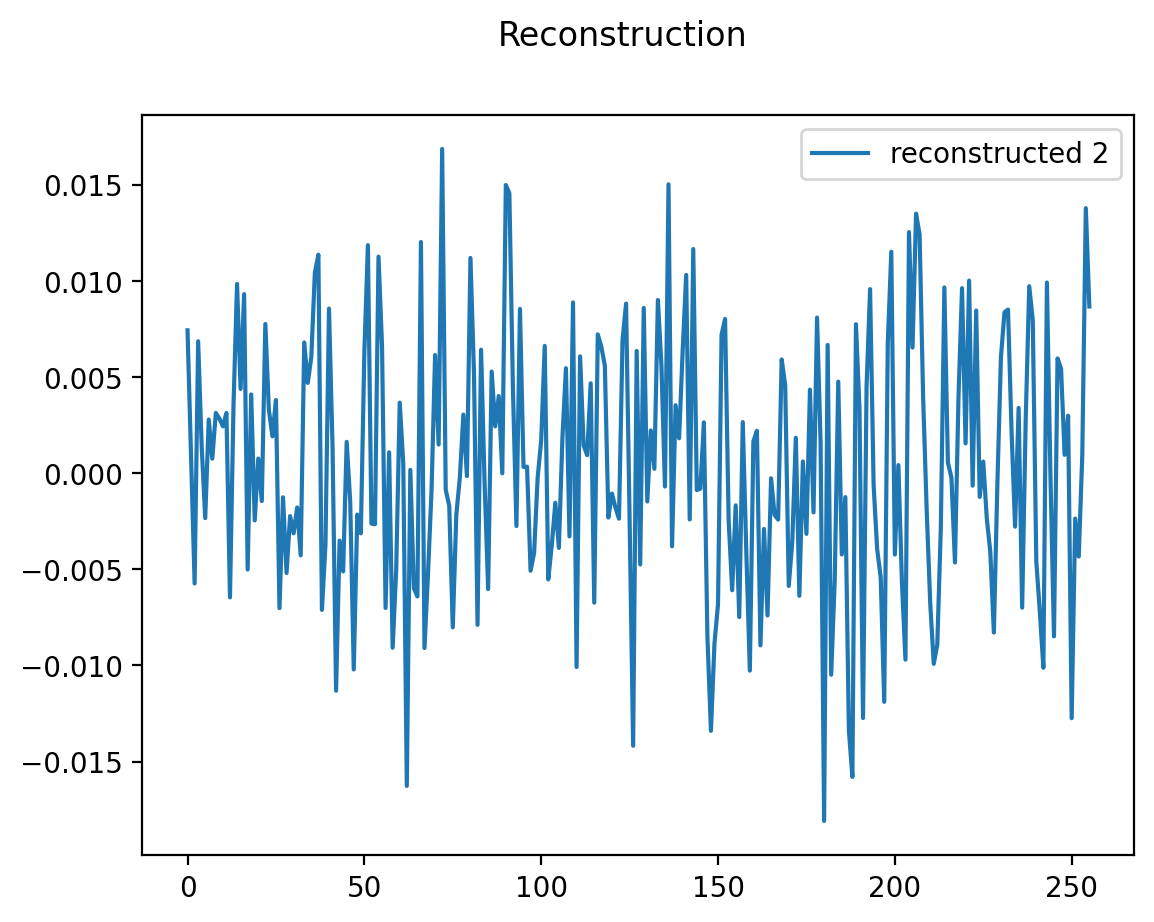

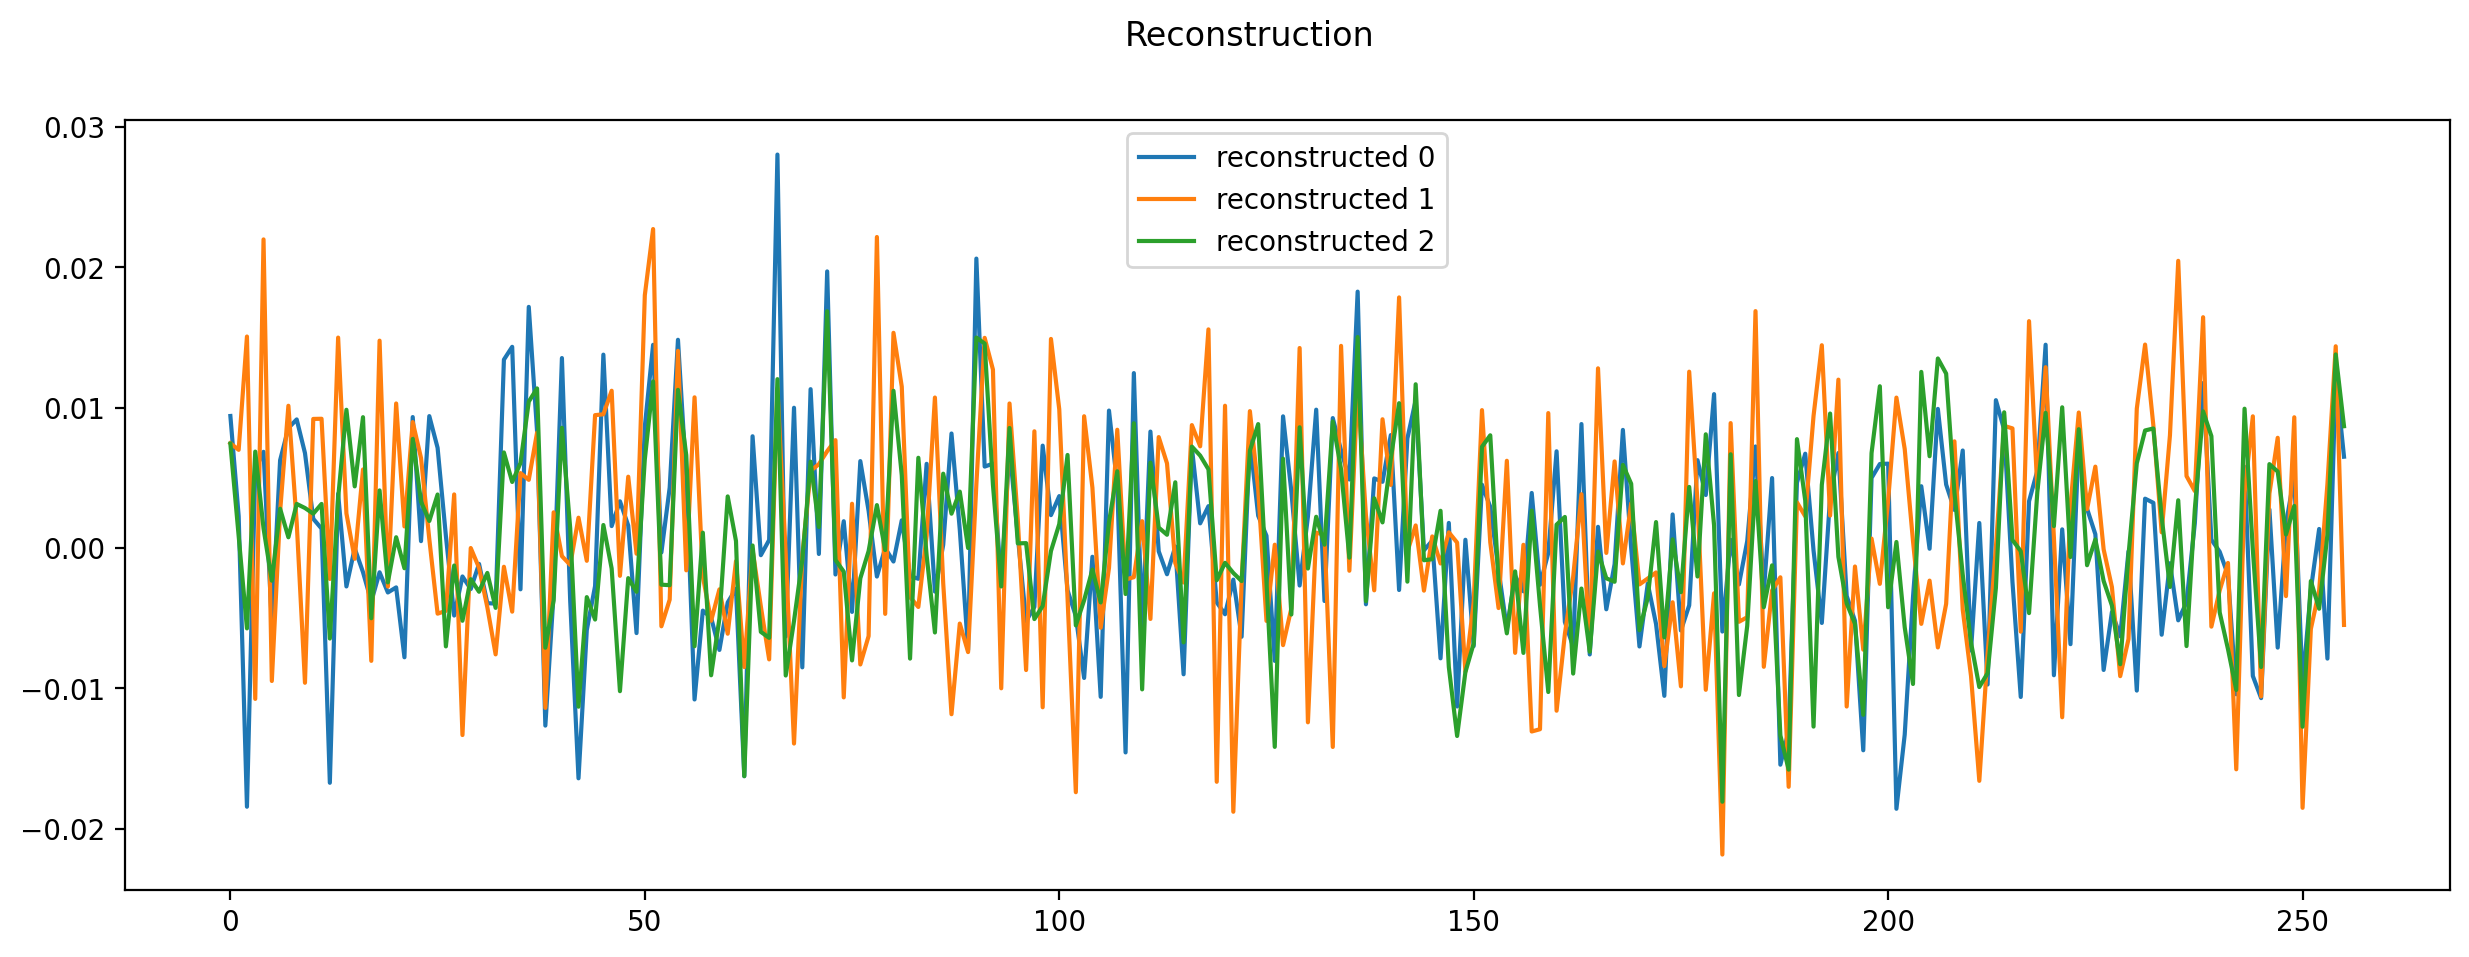

In [25]:
idxs = [20,50,110]
plot_series(x_hat, idxs, label = 'reconstructed ', title='Reconstruction', figsize=(15, 5), merge=True)

In [140]:
embedding_dim = 1
num_embeddings = 256
generation= vqvae_generation(vq_vae_dense, data.copy(), embedding_dim, num_embeddings)
generation.shape


(434, 256)

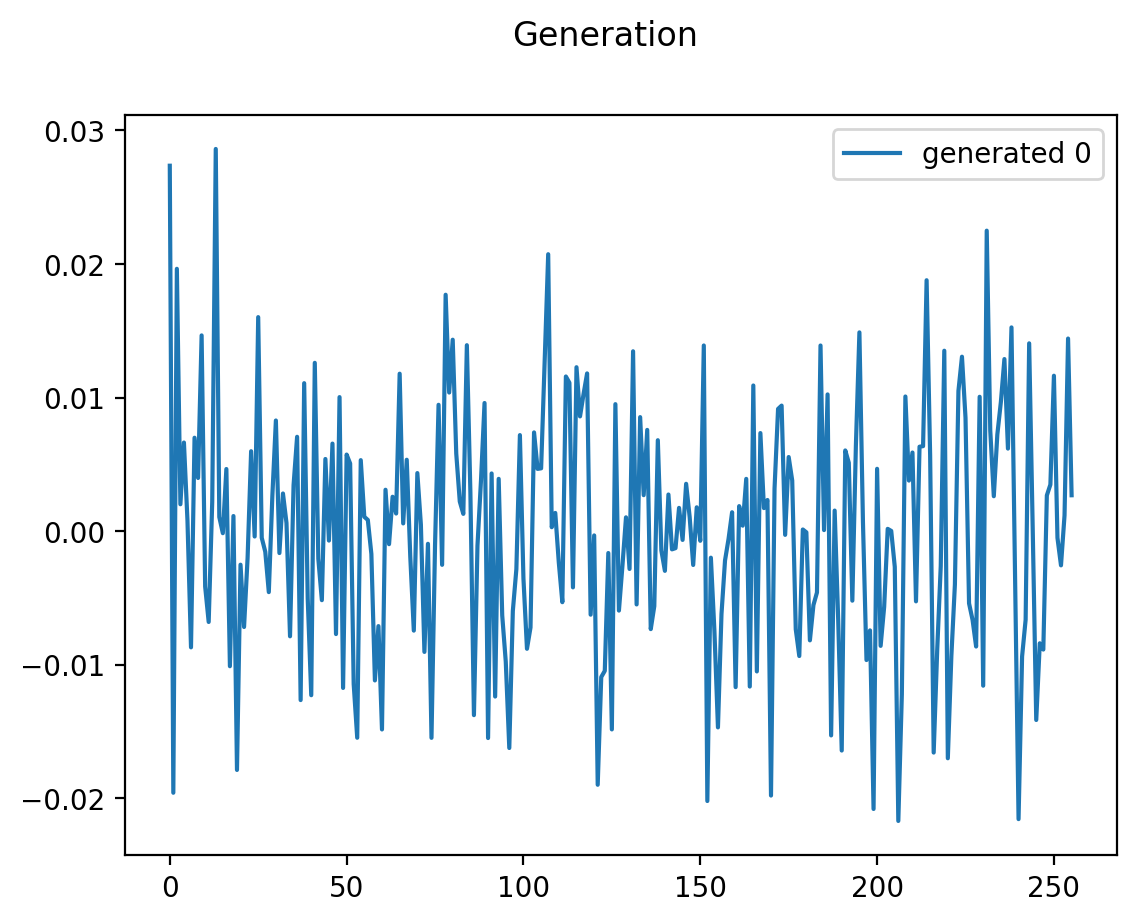

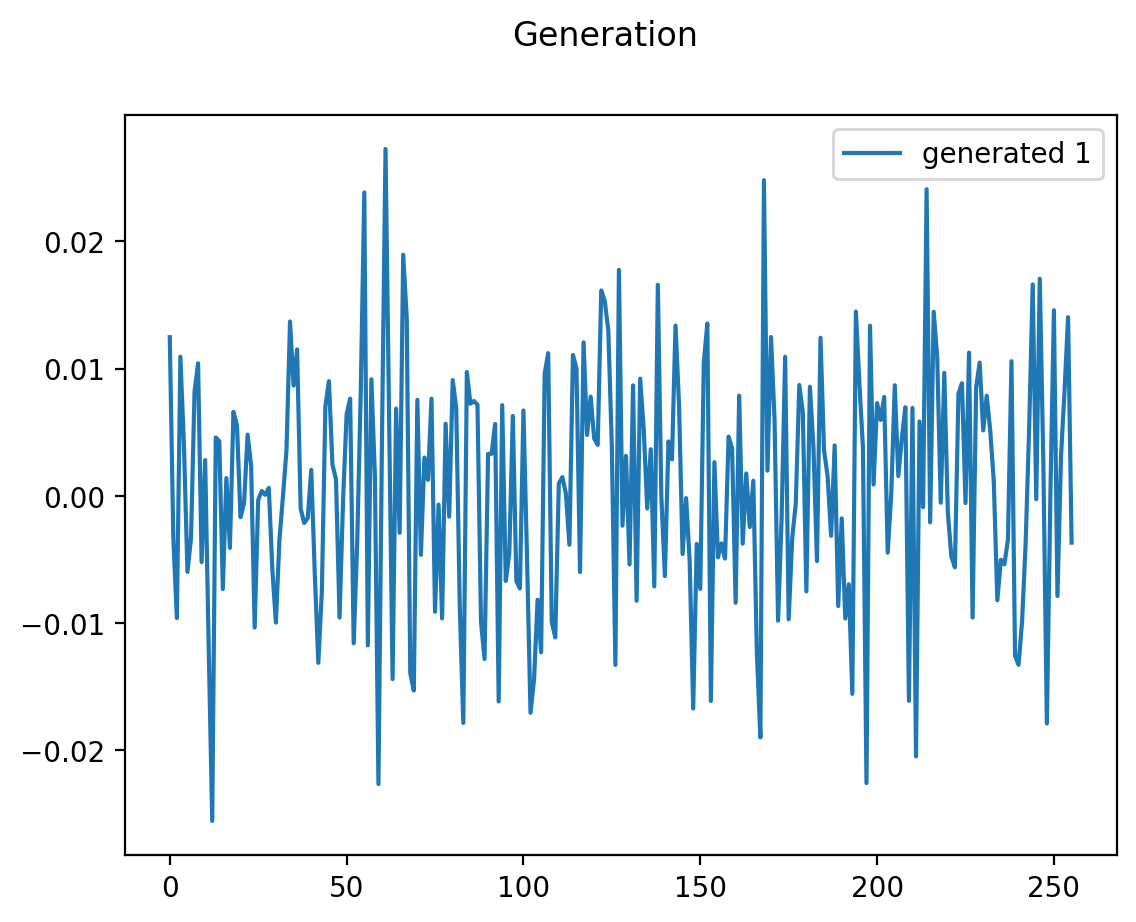

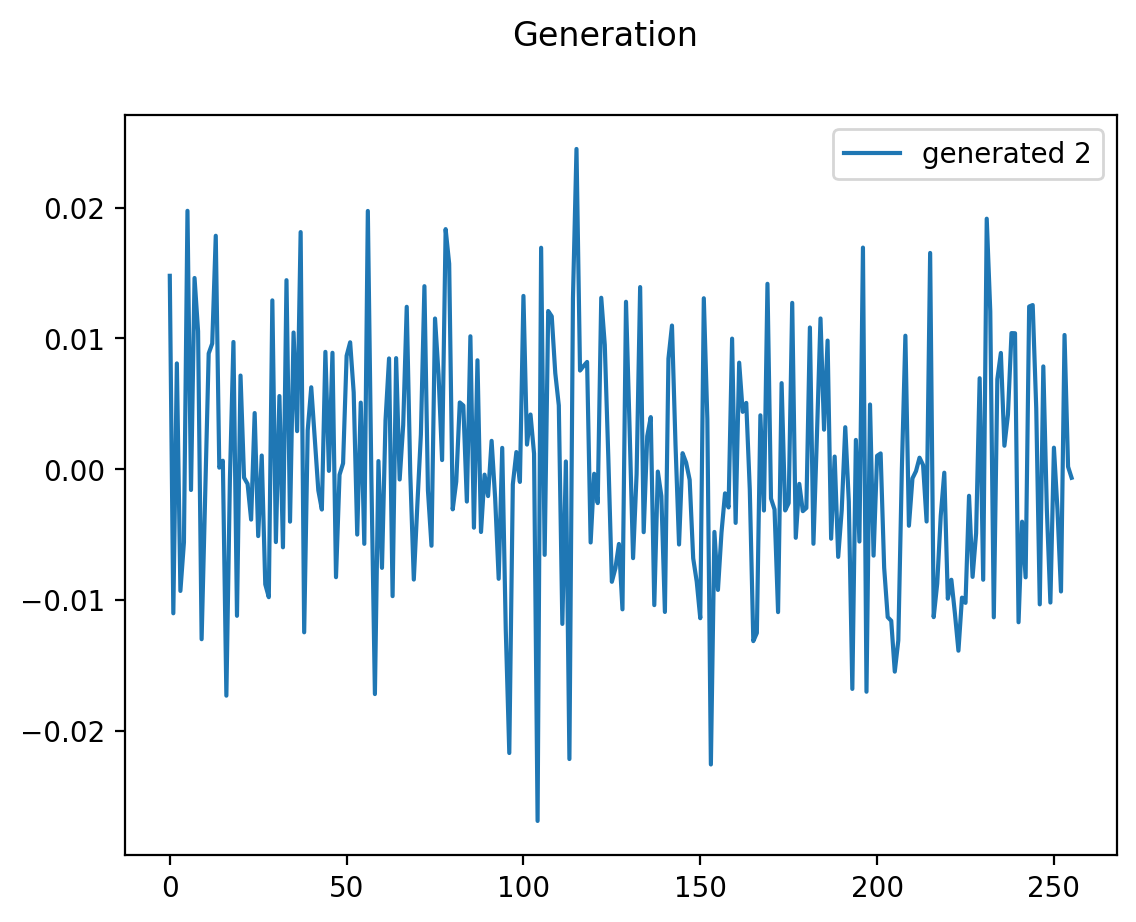

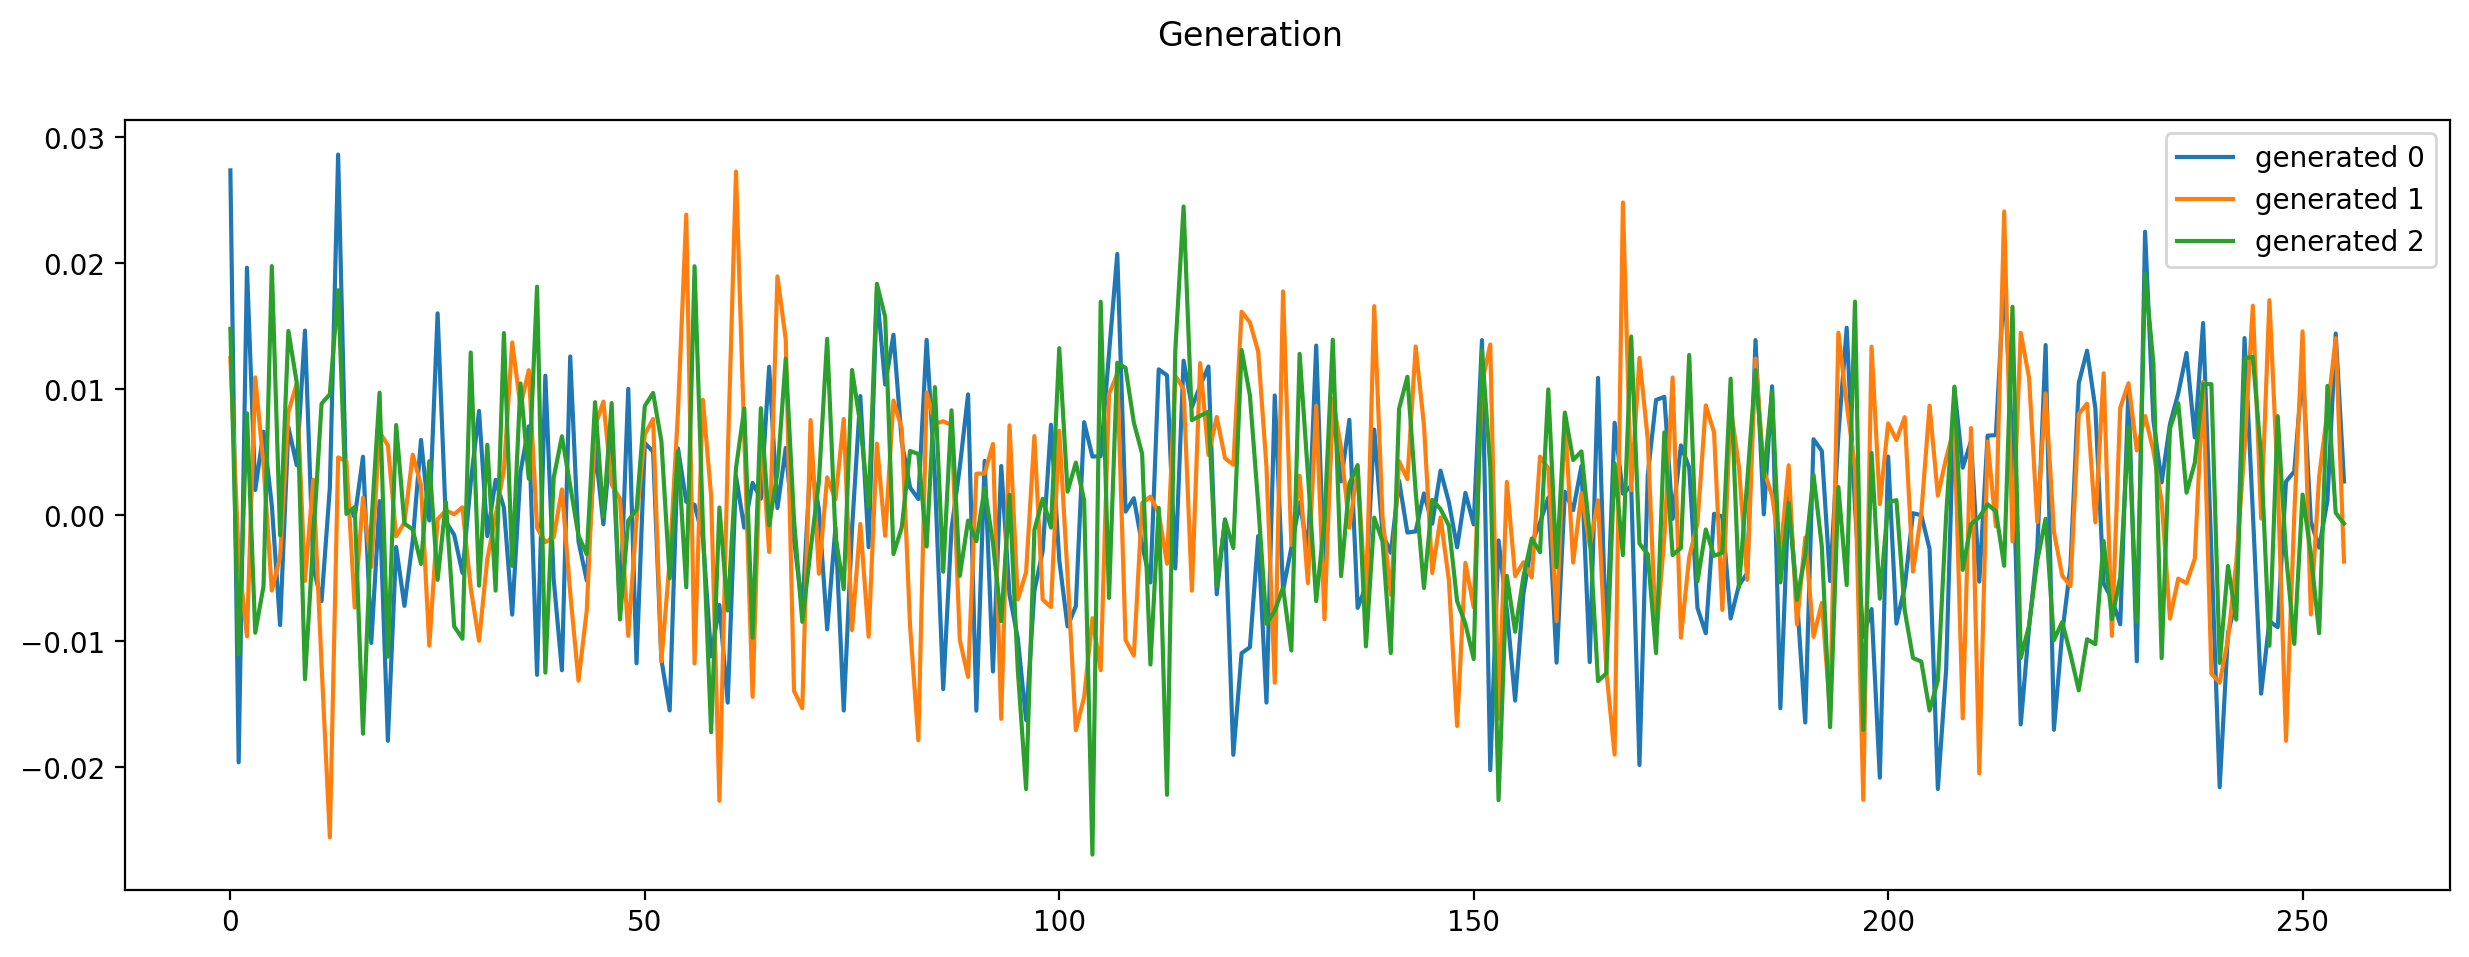

In [141]:
idx = [1, 2, 3]
plot_series(generation, idxs, label = 'generated ', title='Generation', figsize=(15, 5), merge=True)


In [35]:
np.save(gen_dir+'vqvaefd1.npy',generation)
torch.save(vq_vae_dense.state_dict(), models_dir +"vqvaefd1.pth") 

In [27]:
encoding_indices_data = get_encode_indices(vq_vae_dense, data.copy())
encoding_indices_data

e0   e1   e2   e3   e4   e5   e6   e7   e8   e9  ...  e54  e55  e56   
0      152  134  100  193   28   67  253  254   66  192  ...  211   24   21  \
1      100  196  176  193  188   74  179    5   53    5  ...  191   91   27   
2       56  134   87  112  174   40   86   62  187   28  ...   67  192   91   
3      129  160  115  228  202  100  160   73  191   12  ...  100   35  112   
4       23  208  239  222   74  191   51  190  120    0  ...   73   87   27   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
34281  201   73   40  100  129  242  208   56   37  174  ...  184   61  249   
34282  228  198  107   27   76   32  179  237  157  201  ...   62   10  121   
34283  184   12  114   21   56   76   62  179   80  129  ...   36   19  211   
34284  239  145   35   27   90  196  107  193  190  195  ...   44  223  226   
34285  152  190  184   59  119  247  196  178    2   48  ...   16  166   93   

       e57  e58  e59  e60  e61  e62  e63  
0       89  203  193  190   35   14    9  
1      110   10   73  169   84  221  201  
2       93   19   51   19  192  179  101  
3       89   51   91   10  207  100  237  
4       14   28  167  153   28   90  219  
...    ...  ...  ...  ...  ...  ...  ...  
34281   73  162  237  239  211   54  118  
34282   82  110   68   12   74   78  218  
34283   82  160  120  236  166  233   71  
34284  223  130   42  178   76  182   76  
34285    2  188   82   36  175   86   52  

[34286 rows x 64 columns]

In [28]:
encoding = pd.DataFrame(encoding_indices_data.to_numpy().flatten())
encoding.columns = ['encoding']
encoding_count =  encoding.value_counts()
encoding_index = encoding_count.index
encoding_index = np.array(encoding_index)
encoding_index.shape

(256,)

## Inside the model

In [849]:
index = 3
batch= get_batch(data, index, shuffle_stocks=True ,extra_dim=False)
sample =  np.expand_dims(batch[0],axis=0)
print(sample.shape)
x = torch.from_numpy(sample)
print(x.shape)

(1, 256)
torch.Size([1, 256])


Encoder

In [850]:
z = vq_vae_dense.encoder(x)
print(z.shape)

torch.Size([1, 1, 64])


In [851]:
# convert inputs from BCHW -> BHWC
inputs = z.permute(0, 2, 1).contiguous()
input_shape = inputs.shape
print('Input shape: ', input_shape)

Input shape:  torch.Size([1, 64, 1])


In [852]:
# Flatten input
flat_input = inputs.view(-1, embedding_dim)
print('Flat input shape: ', flat_input.shape)

Flat input shape:  torch.Size([64, 1])


In [853]:
embedding =vq_vae_dense._vq_vae._embedding 
print(embedding.weight.detach().cpu().numpy().shape)

(128, 1)


In [854]:
# Calculate distances
distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, embedding.weight.t()))
print('Distances shape: ', distances.shape)


Distances shape:  torch.Size([64, 128])


In [855]:
# Encoding
encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
print(encoding_indices.shape)
encodings = torch.zeros(encoding_indices.shape[0], num_embeddings, device=inputs.device).double()
encodings.scatter_(1, encoding_indices, 1)
print(encodings.shape)

torch.Size([64, 1])
torch.Size([64, 128])


In [856]:
encoding_indices.view(input_shape).shape

torch.Size([1, 64, 1])

In [857]:
# quatize and unflatten 
quantized = torch.matmul(encodings, embedding.weight).view(input_shape)
print('Quantized shape: ', quantized.shape)

Quantized shape:  torch.Size([1, 64, 1])


In [858]:
loss, quantized, perplexity, _, encoding_ = vq_vae_dense._vq_vae(z)
print(quantized.shape)

torch.Size([1, 1, 64])


Embeddings dim latent dim X Num embeddings : (128, 1)


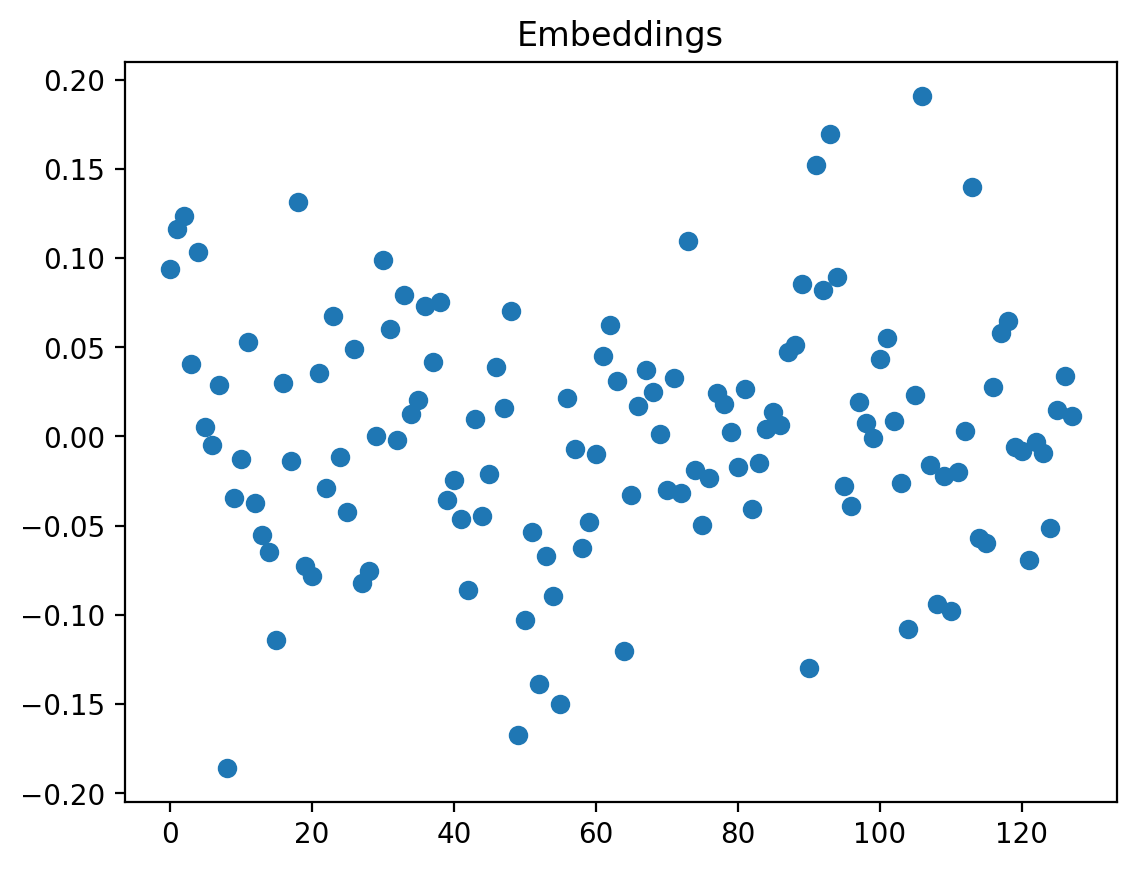

In [859]:
embeddings = embedding.weight.detach().cpu().numpy()
print(f'Embeddings dim latent dim X Num embeddings : {embeddings.shape}')
plt.plot(embeddings, 'o')
plt.title("Embeddings")
plt.show()

In [860]:
encoding_indices_np = encoding_indices.detach().cpu().numpy()
encoding_indices_np = np.squeeze(encoding_indices_np)
# encoding_indices = np.transpose(encoding_indices)
print('Encoding indices shape: ', encoding_indices_np.shape)
encoding_indices_df = pd.DataFrame(encoding_indices_np)
encoding_indices_df.value_counts(sort=True)


Encoding indices shape:  (64,)


34     3
123    3
29     3
100    3
39     2
67     2
6      2
84     2
57     2
44     2
35     2
70     2
103    2
112    2
119    2
122    2
99     1
79     1
98     1
97     1
102    1
95     1
86     1
85     1
80     1
5      1
61     1
75     1
31     1
12     1
14     1
16     1
19     1
22     1
25     1
32     1
69     1
40     1
41     1
47     1
51     1
56     1
60     1
125    1
Name: count, dtype: int64

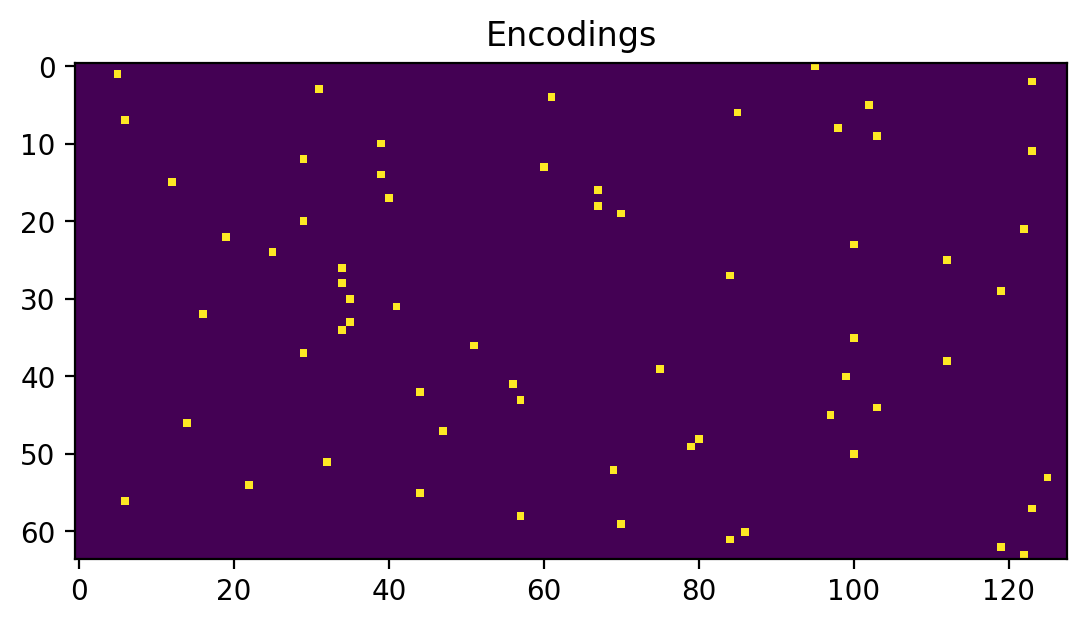

Encodings dim #vectors X Num embeddings : torch.Size([64, 128])


In [861]:
plt.imshow(encodings)
plt.title("Encodings")
plt.show()
print(f'Encodings dim #vectors X Num embeddings : {encodings.shape}')

In [862]:
input_np = inputs.detach().cpu().numpy()
input_np = np.squeeze(input_np)
quantized_np = quantized.detach().cpu().numpy()
quantized_np = np.squeeze(quantized_np)
print('Input shape: ', input_np.shape)
print('Quantized shape: ', quantized_np.shape)

Input shape:  (64,)
Quantized shape:  (64,)


In [863]:
input_np

array([-0.02679729,  0.0048658 , -0.00883347,  0.05973517,  0.04489006,
        0.00900718,  0.01403144, -0.00490469,  0.00809566, -0.02575261,
       -0.03555835, -0.00930398,  0.00035603, -0.01066437, -0.03590542,
       -0.03669329,  0.03722875, -0.02510848,  0.03790136, -0.0295432 ,
        0.00031361, -0.00317451, -0.07261667,  0.04282833, -0.04225257,
        0.0031586 ,  0.01292046,  0.0047888 ,  0.01216579, -0.00518217,
        0.02047823, -0.04654412,  0.02938177,  0.0200084 ,  0.01219029,
        0.04329918, -0.05315321,  0.00049076,  0.00315741, -0.05030993,
       -0.00075692,  0.02225484, -0.04497334, -0.00676604, -0.02557905,
        0.01957704, -0.06372122,  0.01529393, -0.01683528,  0.00195409,
        0.04402901, -0.00198932,  0.00090574,  0.01414755, -0.02835543,
       -0.0442621 , -0.00428989, -0.00860795, -0.0063005 , -0.03012762,
        0.00671176,  0.00435825, -0.00514546, -0.00394138])

In [864]:
quantized_np

array([-0.02757939,  0.00535162, -0.00901778,  0.06021037,  0.04530151,
        0.00891236,  0.01356658, -0.00454486,  0.00773308, -0.02597638,
       -0.03584959, -0.00901778,  0.00013432, -0.01002297, -0.03584959,
       -0.03743369,  0.03722808, -0.02462358,  0.03722808, -0.03008061,
        0.00013432, -0.00336239, -0.07257448,  0.0434053 , -0.04260674,
        0.00328203,  0.01250428,  0.00432979,  0.01250428, -0.00564491,
        0.02042408, -0.04610098,  0.03000754,  0.02042408,  0.01250428,
        0.0434053 , -0.05327654,  0.00013432,  0.00328203, -0.04977313,
       -0.00097052,  0.02159344, -0.04447452, -0.00677237, -0.02597638,
        0.01916284, -0.06457152,  0.01585825, -0.01724896,  0.00232797,
        0.0434053 , -0.00224529,  0.00126954,  0.01469107, -0.02864535,
       -0.04447452, -0.00454486, -0.00901778, -0.00677237, -0.03008061,
        0.00651438,  0.00432979, -0.00564491, -0.00336239])

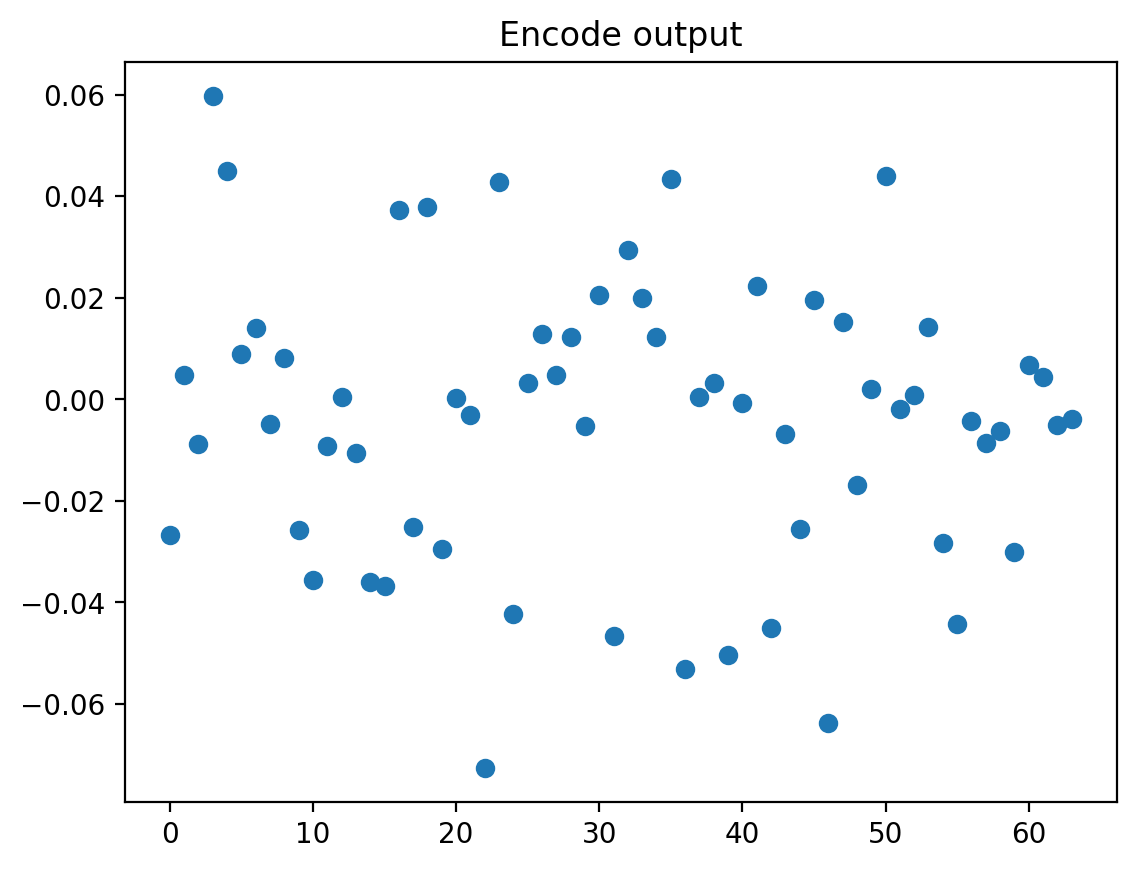

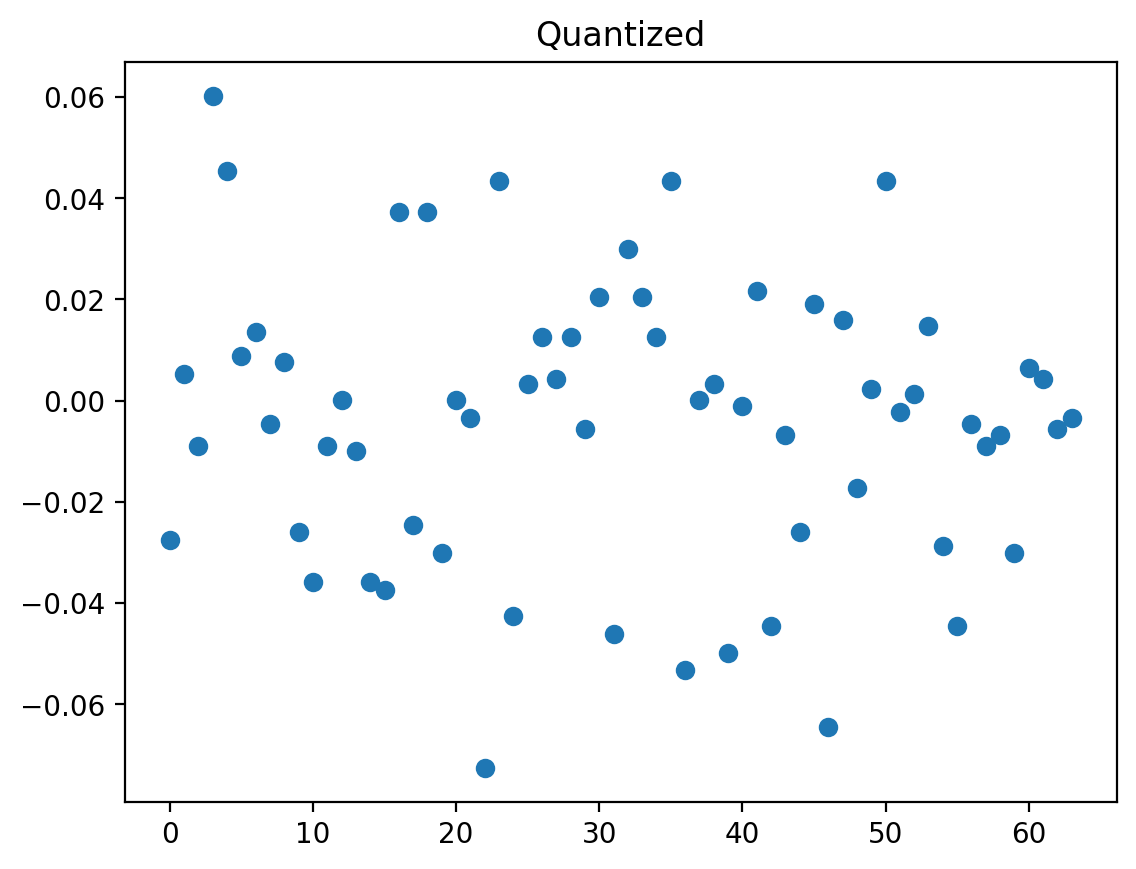

Encode output dim: (64,)
Quantized dim: (64,)


In [865]:

plt.plot(input_np, 'o')
plt.title("Encode output")
# plt.axis("off")
plt.show()

plt.plot(quantized_np, 'o')
plt.title("Quantized")
# plt.axis("off")
plt.show()

print(f'Encode output dim: {input_np.shape}')
print(f'Quantized dim: {quantized_np.shape}')

# VQ-VAE Fully Convolutional

    input
    torch.Size([434, 1, 256])
    conv1
    torch.Size([434, 32, 128])
    conv2
    torch.Size([434, 64, 64])
    conv3
    torch.Size([434, 1, 32])
    input shape:  torch.Size([434, 1, 32])
    input shape BCL -> BLC:  torch.Size([434, 32, 1])
    flat input shape:  torch.Size([13888, 1])
    encoding_indices shape:  torch.Size([13888, 1])
    encodings shape:  torch.Size([13888, 512])
    quantized shape:  torch.Size([434, 32, 1])
    encoding_indices shape:  torch.Size([434, 32])
    encoding_indices shape BLC -> BCL:  torch.Size([434, 32])
    quantized shape BLC -> BCL:  torch.Size([434, 1, 32])
    encodings shape:  torch.Size([434, 32, 512])
    decoder input
    torch.Size([434, 1, 32])
    deconv1
    torch.Size([434, 64, 64])
    deconv2
    torch.Size([434, 32, 128])
    deconv3
    torch.Size([434, 1, 256])
    flatten
    torch.Size([434, 256])
    linear
    torch.Size([434, 256])

In [36]:
class VQ_VAE_Convolutional(nn.Module):
    def __init__(self,
                 num_embeddings=300, embedding_dim=1, commitment_cost=0.25, decay=0, **kwargs ):
        super(VQ_VAE_Convolutional, self).__init__(**kwargs )
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay

        self.encoder = nn.Sequential(
            # PrintLayer('input'),
            nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1).double(),
            # PrintLayer('conv1'),    
            nn.ReLU().double(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1).double(),
            # PrintLayer('conv2'),
            nn.ReLU().double(),
            nn.Conv1d(64, self.embedding_dim , kernel_size=3, stride=2, padding=1).double(),
            # PrintLayer('conv3'),
            # nn.ReLU().double(),
            # nn.Flatten().double(),  
            # PrintLayer('flatten'), 

        )

          
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(self.num_embeddings, self.embedding_dim,
                                              self.commitment_cost, self.decay)
        else:
            self._vq_vae = VectorQuantizer(self.num_embeddings, self.embedding_dim,
                                           self.commitment_cost)

        
        self.decoder = nn.Sequential(
            # PrintLayer('decoder input'),
            # UnFlatten(),
            # PrintLayer('unflatten'),
            nn.ConvTranspose1d(self.embedding_dim , 64, kernel_size=3, stride=2, padding=1 ,output_padding=1).double(),
            # PrintLayer('deconv1'),
            nn.ReLU().double(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1).double(),
            # PrintLayer('deconv2'),
            nn.ReLU().double(),
            nn.ConvTranspose1d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1).double(),
            # PrintLayer('deconv3'),
            nn.ReLU().double(),
            # nn.ConvTranspose1d(1, 1, kernel_size=1, stride=1, padding=0, output_padding=0).double(),
            # PrintLayer('deconv4'),
        )

        self.last_layer = nn.Sequential(
            nn.Flatten().double(),
            # PrintLayer('flatten'),
            nn.Linear(256, 256).double(),
            # PrintLayer('linear'),
            # nn.LeakyReLU().double(),
            UnFlatten3(),

            # PrintLayer('unflatten'),
        )

    def forward(self, x):
        z = self.encoder(x)
        # z = z.view(z.size(0), z.size(2), 1)
        loss, quantized, perplexity, encodings, encoding_indices = self._vq_vae(z)
        x_recon = self.decoder(quantized)
        x_recon = self.last_layer(x_recon)
        return x_recon, loss, perplexity, encodings, encoding_indices, quantized 
class UnFlatten3(nn.Module):
    def forward(self, input, last_dim=256):
        return input.view(input.size(0), 1, last_dim)

In [39]:
# num_hiddens = 64


embedding_dim = 1
num_embeddings = 512

commitment_cost = 0.25 # beta 0.25 of the paper [0.1, 2]

decay = 0

learning_rate = 1e-3

In [40]:
vq_vae_conv = VQ_VAE_Convolutional(
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

Epoch 1/30, Loss=0.0014273135025445393, recon_error=0.0014033615594693351, vq_loss: 2.3951943075203757e-05
Epoch 2/30, Loss=0.0010473848580127005, recon_error=0.001047367681988363, vq_loss: 1.7176024338014462e-08
Epoch 3/30, Loss=0.0007978673292243785, recon_error=0.0007978618081289689, vq_loss: 5.5210954093869e-09
Epoch 4/30, Loss=0.0006256358908988639, recon_error=0.0006256315159844986, vq_loss: 4.374914365125466e-09
Epoch 5/30, Loss=0.0005087122948204273, recon_error=0.0005087091484233834, vq_loss: 3.1463970441577082e-09
Epoch 6/30, Loss=0.0004308467429577811, recon_error=0.0004308442947792612, vq_loss: 2.4481785202033844e-09
Epoch 7/30, Loss=0.0003800788909438847, recon_error=0.00038007699914850544, vq_loss: 1.8917953792989997e-09
Epoch 8/30, Loss=0.00034771348209611973, recon_error=0.0003477110158505257, vq_loss: 2.466245593974983e-09
Epoch 9/30, Loss=0.0003275514643357565, recon_error=0.0003275490292103913, vq_loss: 2.4351253651569166e-09
Epoch 10/30, Loss=0.0003152852661190196, 

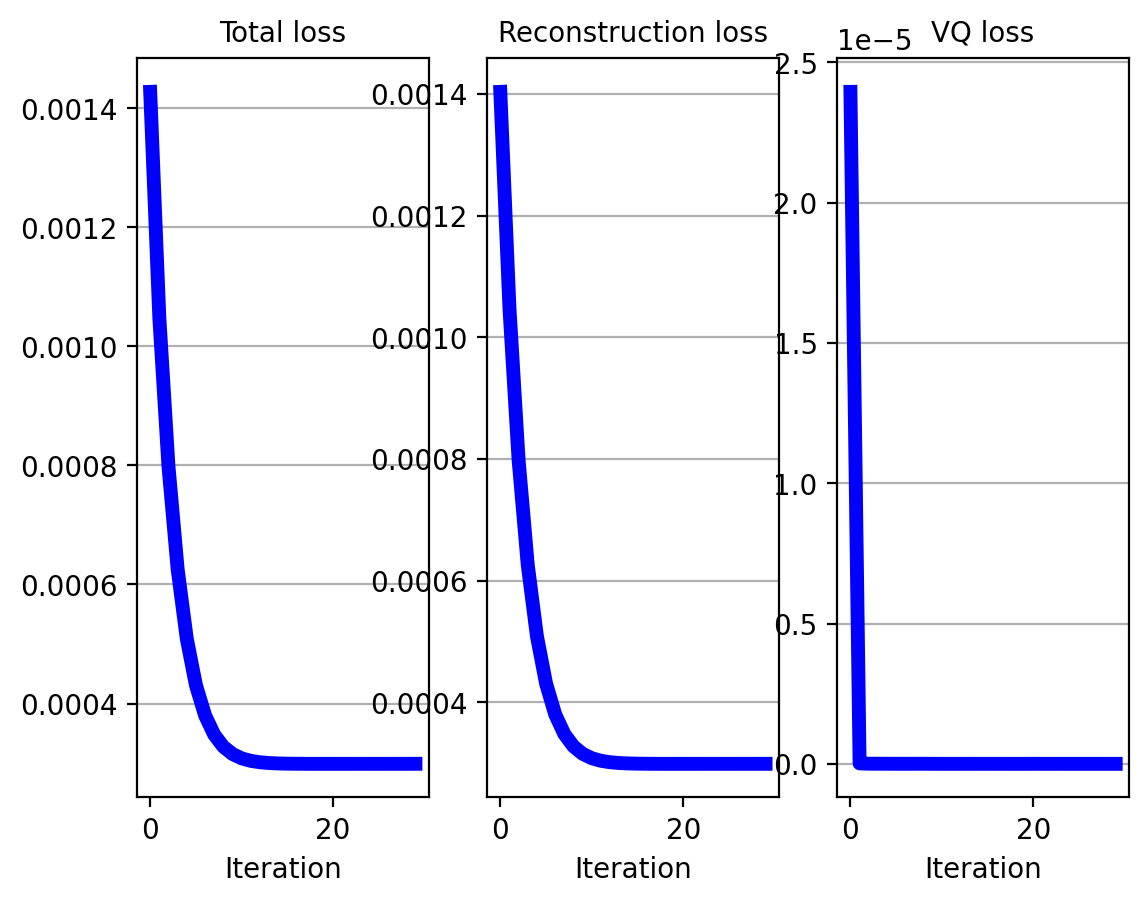

In [41]:
vq_vae_conv = train_vq_vae(vq_vae_conv, data, epochs=30, extra_dim=True, learning_rate=0.0001)

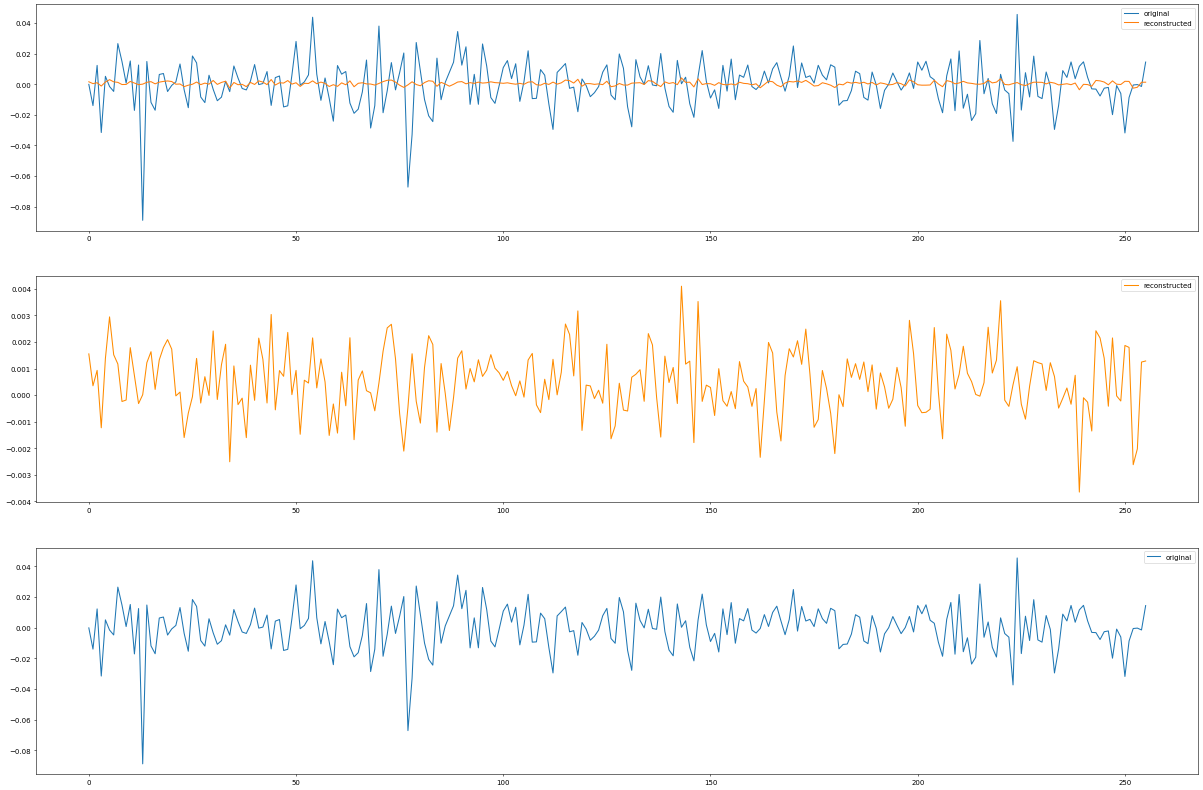

In [42]:
batch_idx = 0
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_conv, data, extra_dim=True)

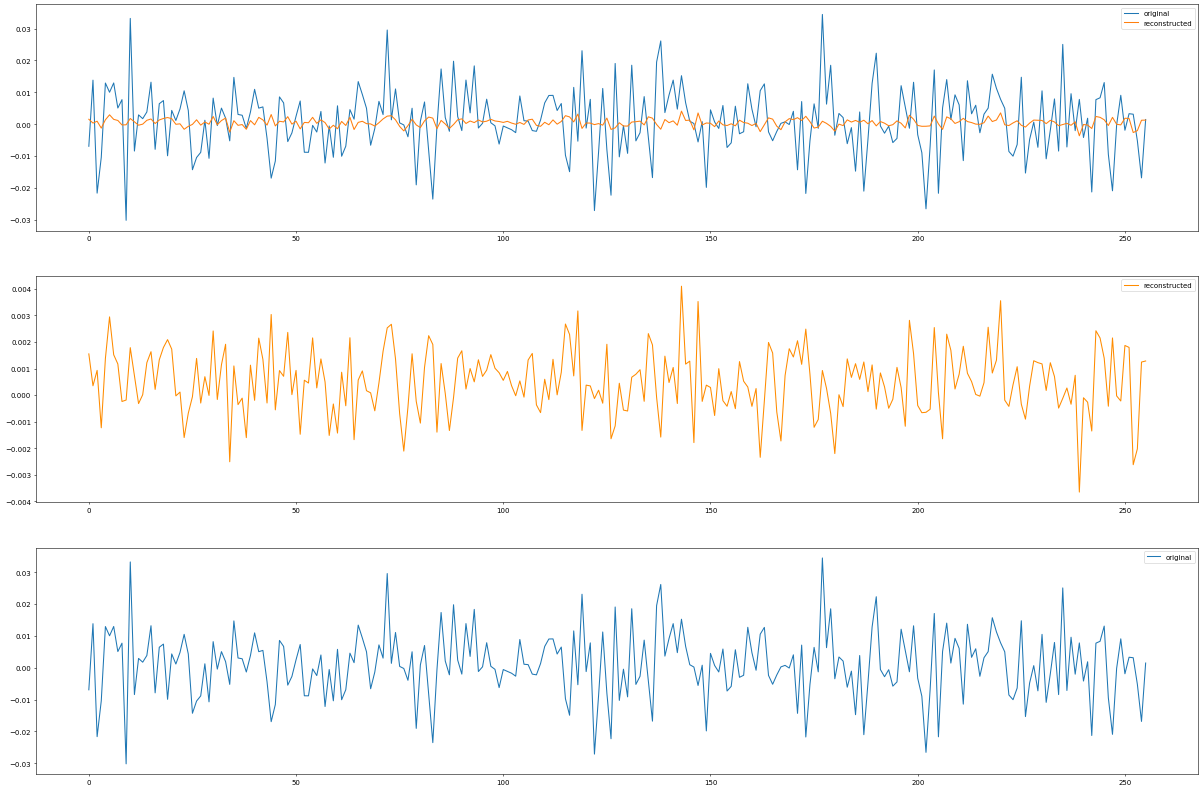

In [43]:
batch_idx = 40
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_conv, data, extra_dim=True)

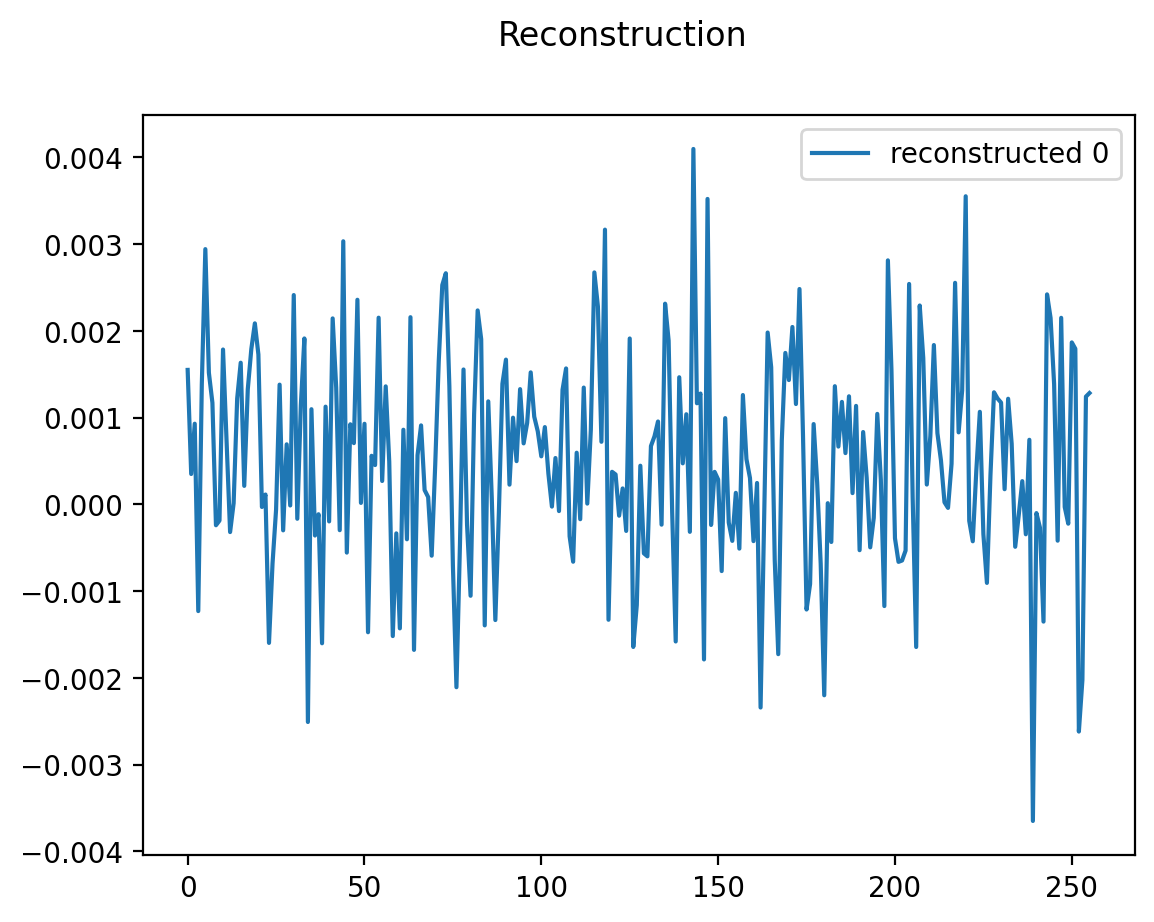

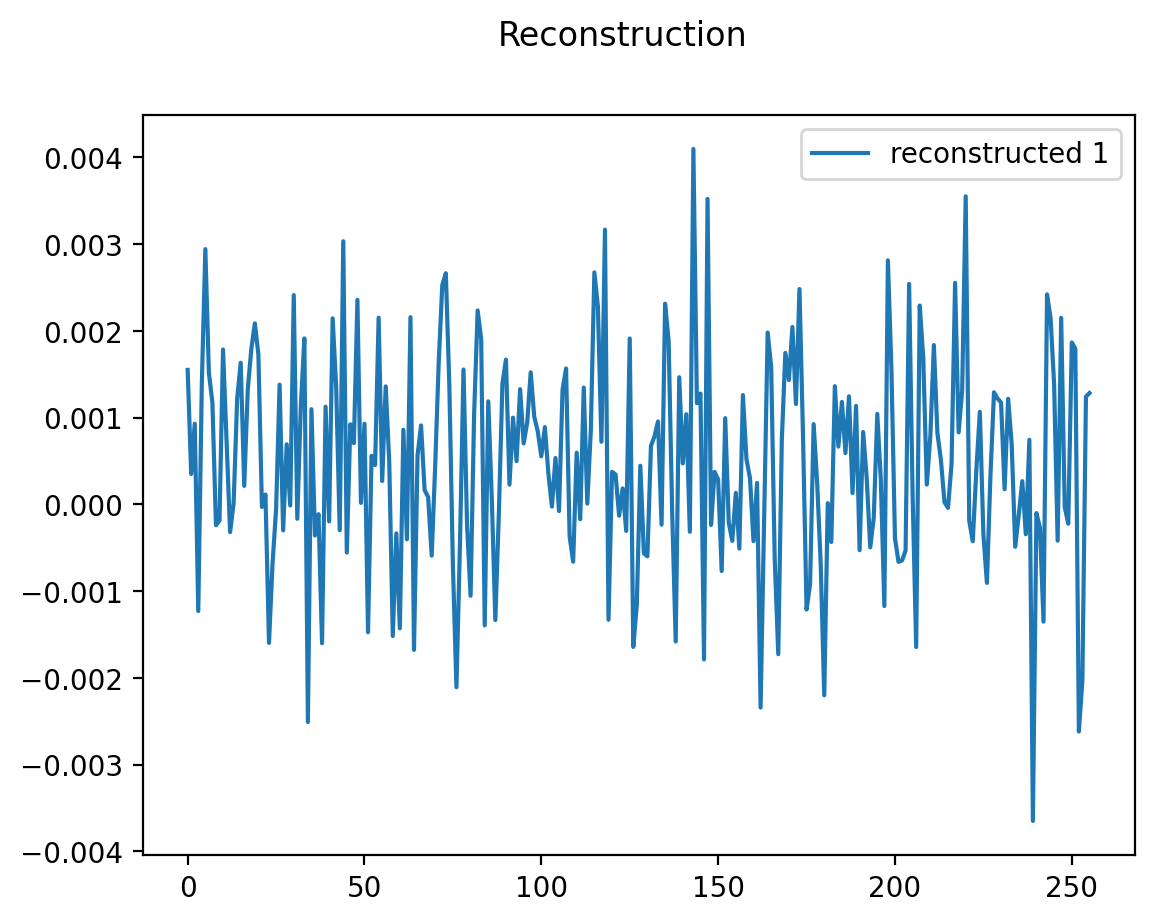

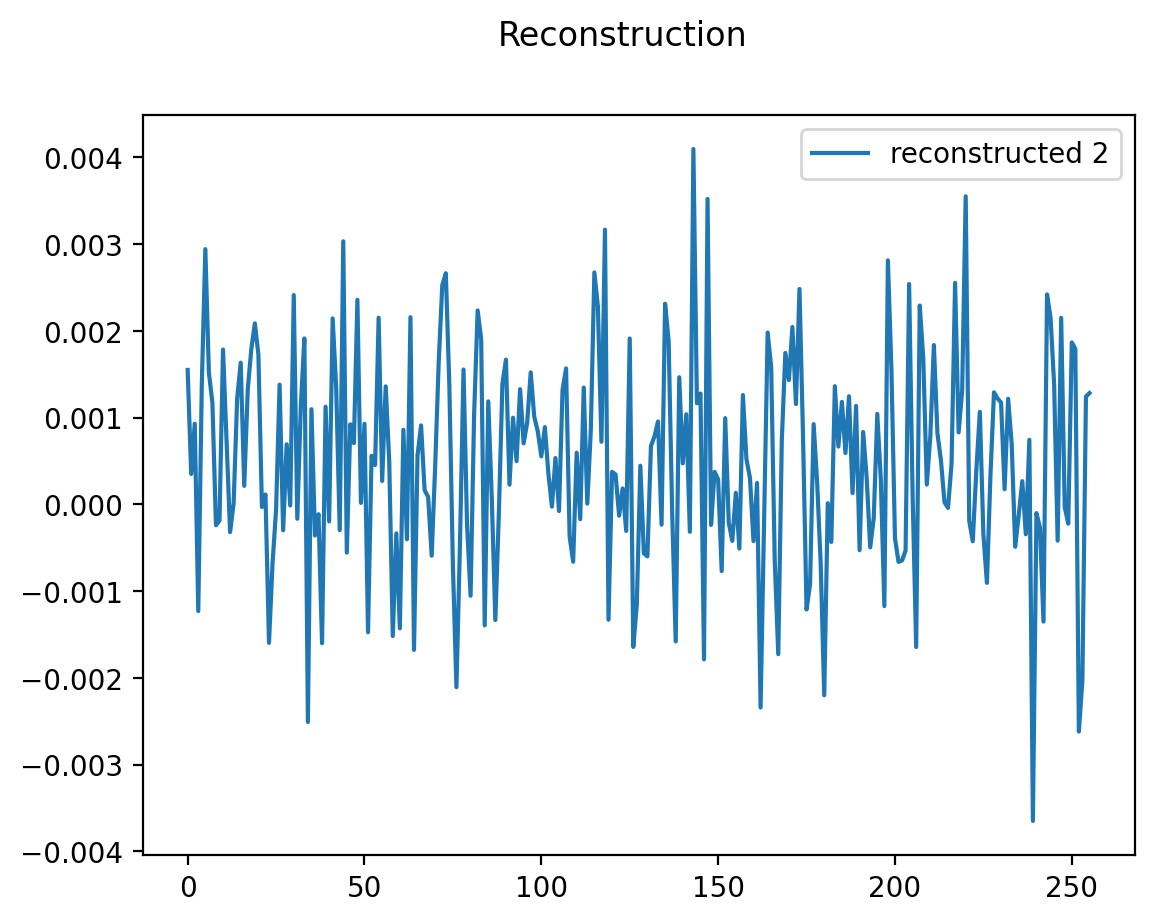

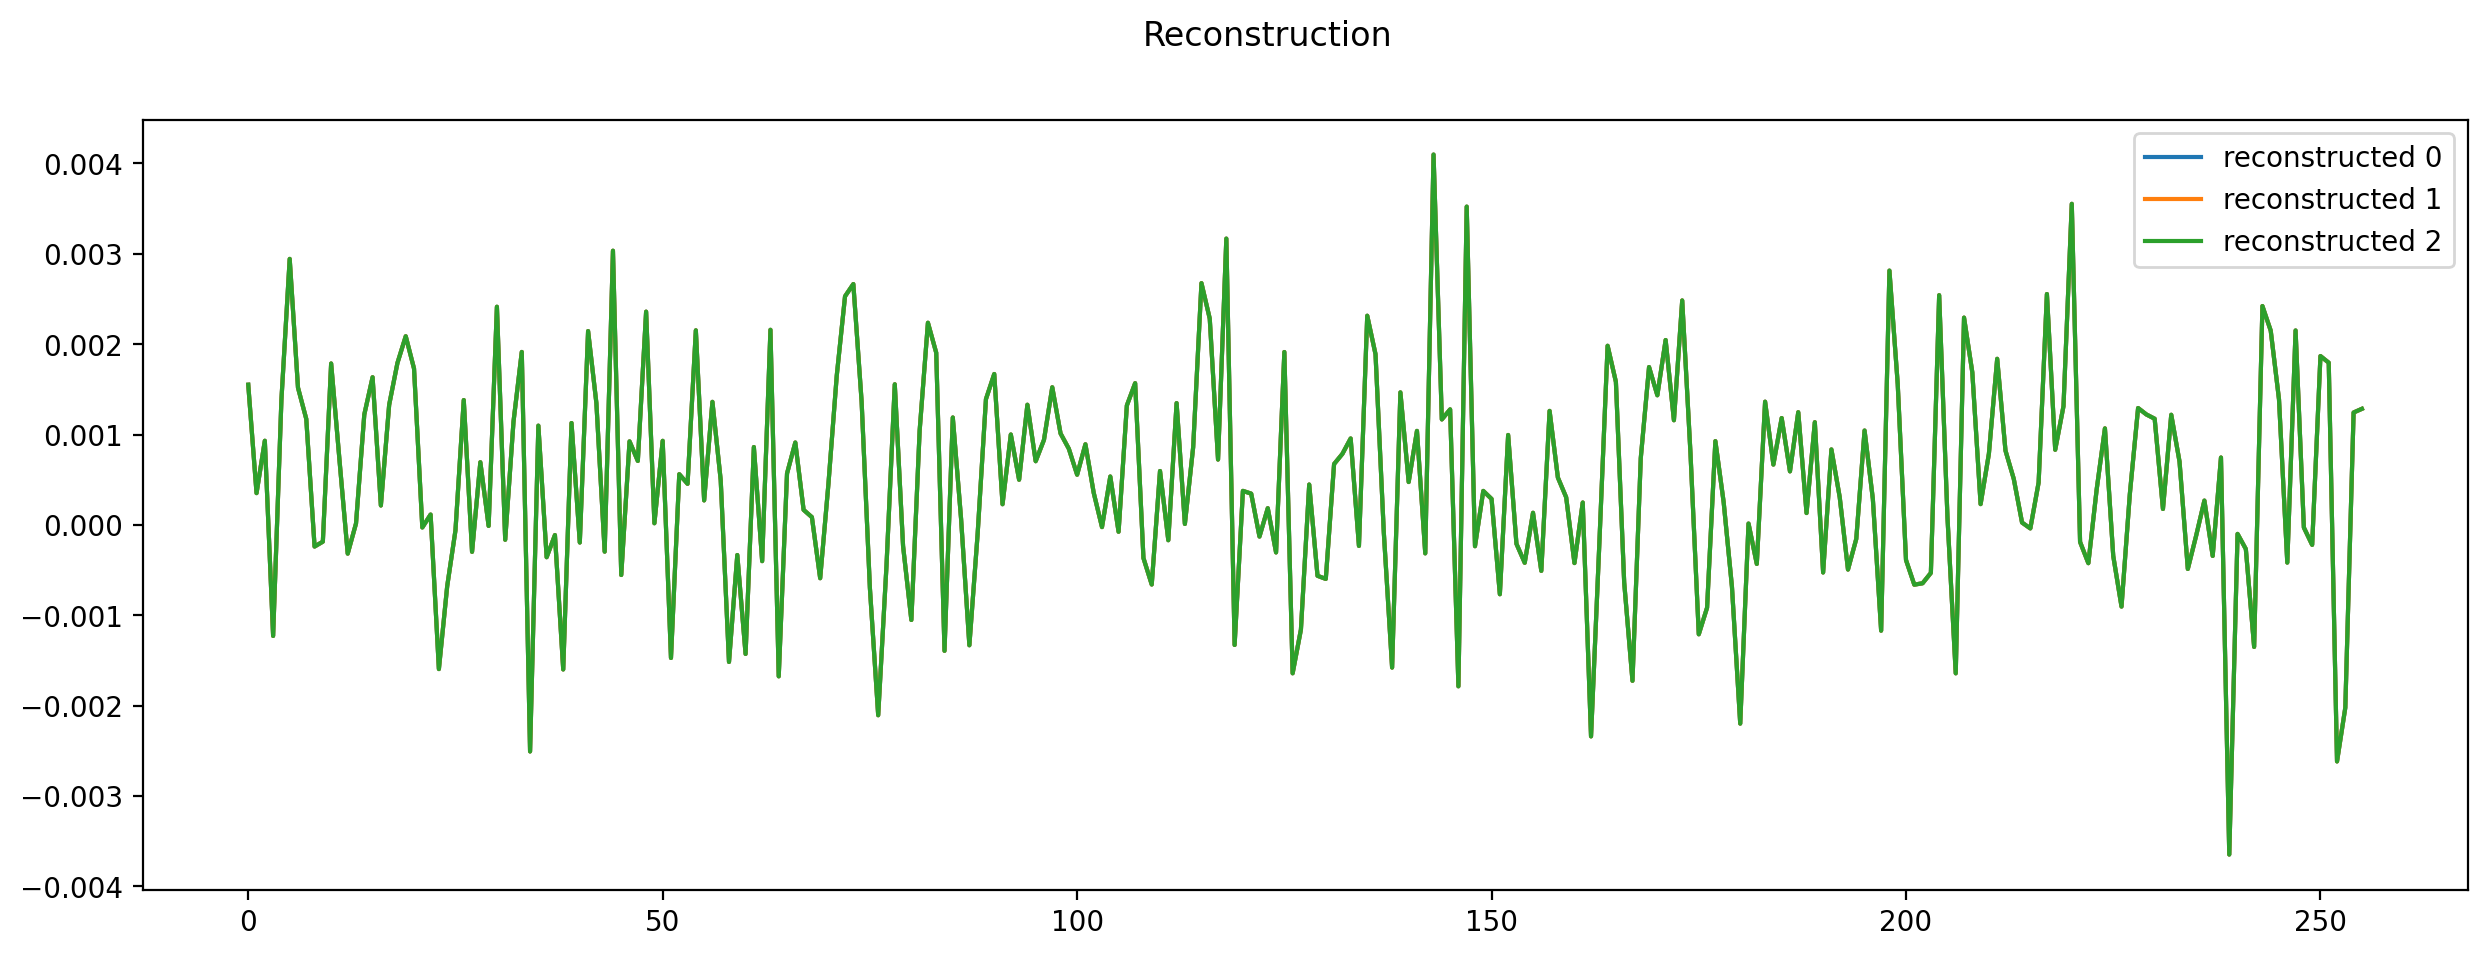

In [51]:
idxs = [20,50,110]
plot_series(x_hat, idxs, label = 'reconstructed ', title='Reconstruction', figsize=(15, 5), merge=True)

# VQ-VAE Fully convolutional model with embedding dimension > 1

    input
    torch.Size([434, 1, 256])
    conv1
    torch.Size([434, 32, 127])
    conv2
    torch.Size([434, 64, 64])
    conv3
    torch.Size([434, 16, 64])
    input shape:  torch.Size([434, 16, 64])
    input shape BCL -> BLC:  torch.Size([434, 64, 16])
    flat input shape:  torch.Size([27776, 16])
    encoding_indices shape:  torch.Size([27776, 1])
    encodings shape:  torch.Size([27776, 128])
    quantized shape:  torch.Size([434, 64, 16])
    encoding_indices shape:  torch.Size([434, 64])
    encoding_indices shape BLC -> BCL:  torch.Size([434, 64])
    quantized shape BLC -> BCL:  torch.Size([434, 16, 64])
    encodings shape:  torch.Size([434, 64, 128])
    decoder input
    torch.Size([434, 16, 64])
    deconv1
    torch.Size([434, 64, 64])
    deconv2
    torch.Size([434, 32, 128])
    deconv3
    torch.Size([434, 1, 256])

In [83]:
class VQ_VAE_Convolutional2(nn.Module):
    def __init__(self,
                 num_embeddings=300, embedding_dim=1, commitment_cost=0.25, decay=0, **kwargs ):
        super(VQ_VAE_Convolutional2, self).__init__(**kwargs )
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay

        self.encoder = nn.Sequential(
            # PrintLayer('input'),
            nn.Conv1d(1, 32, kernel_size=3, stride=2).double(),
            # PrintLayer('conv1'),    
            nn.ReLU().double(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1).double(),
            # PrintLayer('conv2'),
            nn.ReLU().double(),
            nn.Conv1d(64, self.embedding_dim, kernel_size=1, stride=1).double(),
            # PrintLayer('conv3'),
            # nn.ReLU().double(),
            # nn.Flatten().double(),  
            # PrintLayer('flatten'), 
        )
  
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(self.num_embeddings, self.embedding_dim,
                                              self.commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(self.num_embeddings, self.embedding_dim,
                                           self.commitment_cost)

        self.decoder = nn.Sequential(
            # PrintLayer('decoder input'),
            # UnFlatten(),
            # PrintLayer('unflatten'),
            nn.ConvTranspose1d(self.embedding_dim, 64, kernel_size=1, stride=1).double(),
            # PrintLayer('deconv1'),
            nn.ReLU().double(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1).double(),
            # PrintLayer('deconv2'),
            nn.ReLU().double(),
            nn.ConvTranspose1d(32, 1, kernel_size=2, stride=2, output_padding=0).double(),
            # PrintLayer('deconv3'),
            # nn.ReLU().double(),
            # nn.ConvTranspose1d(1, 1, kernel_size=1, stride=1, padding=0, output_padding=0).double(),
            # PrintLayer('deconv4'),
        )

        self.last_layer = nn.Sequential(
            nn.Flatten().double(),
            PrintLayer('flatten'),
            nn.Linear(256, 256).double(),
            PrintLayer('linear'),
            # nn.LeakyReLU().double(),
            UnFlatten3(),

            # PrintLayer('unflatten'),
        )

    def forward(self, x):
        z = self.encoder(x)
        # z = z.view(z.size(0), z.size(2), 1)
        loss, quantized, perplexity, encodings, encoding_indices = self._vq_vae(z)
        x_recon = self.decoder(quantized)
        # x_recon = self.last_layer(x_recon)
        return x_recon, loss, perplexity, encodings, encoding_indices, quantized 
class UnFlatten3(nn.Module):
    def forward(self, input, last_dim=256):
        return input.view(input.size(0), 1, last_dim)

In [84]:
# num_hiddens = 64
device = 'cpu'

embedding_dim = 16
num_embeddings = 128
commitment_cost = 0.25 # beta 0.25 of the paper [0.1, 2]

decay = 0

learning_rate = 1e-3

In [85]:
vq_vae_conv2 = VQ_VAE_Convolutional2(
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

Epoch 1/30, Loss=0.029144389273898143, recon_error=0.016650262600014478, vq_loss: 0.012494126673883658
Epoch 2/30, Loss=0.0006595857155692502, recon_error=0.0004024688269667964, vq_loss: 0.00025711688860245415
Epoch 3/30, Loss=0.0005796300013581207, recon_error=0.00037325216230215985, vq_loss: 0.0002063778390559605
Epoch 4/30, Loss=0.0006042319258200889, recon_error=0.0003000926512173829, vq_loss: 0.00030413927460270547
Epoch 5/30, Loss=0.00042216041912309814, recon_error=0.0002618423425807071, vq_loss: 0.00016031807654239092
Epoch 6/30, Loss=0.000370728396288231, recon_error=0.0002452058561271727, vq_loss: 0.00012552254016105844
Epoch 7/30, Loss=0.0003784228441644089, recon_error=0.00022662833818503834, vq_loss: 0.00015179450597937072
Epoch 8/30, Loss=0.00035179279633364114, recon_error=0.00019798116654263208, vq_loss: 0.00015381162979100907
Epoch 9/30, Loss=0.00031362383364488, recon_error=0.0001766490847374988, vq_loss: 0.0001369747489073812
Epoch 10/30, Loss=0.00028886562520080304,

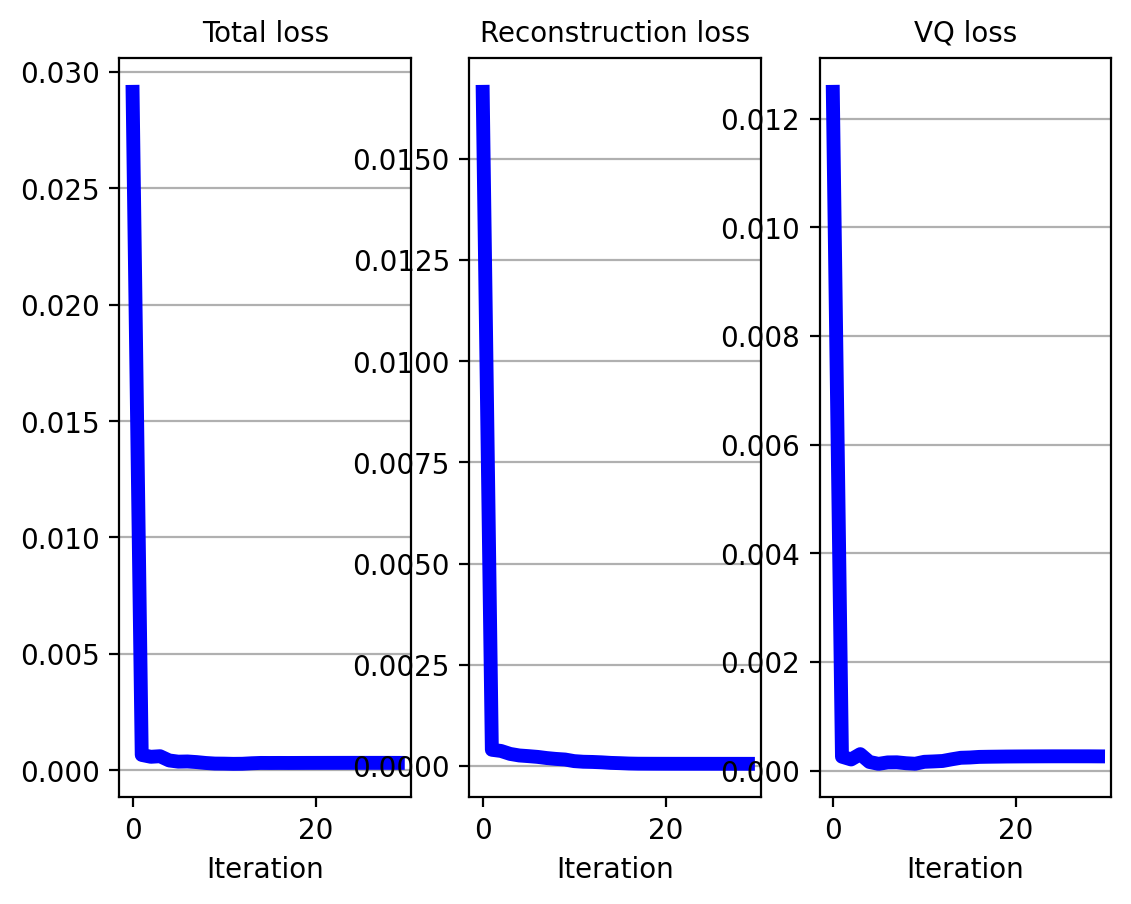

In [86]:
vq_vae_conv2 = train_vq_vae(vq_vae_conv2, data, epochs=30, extra_dim=True, learning_rate=0.001)

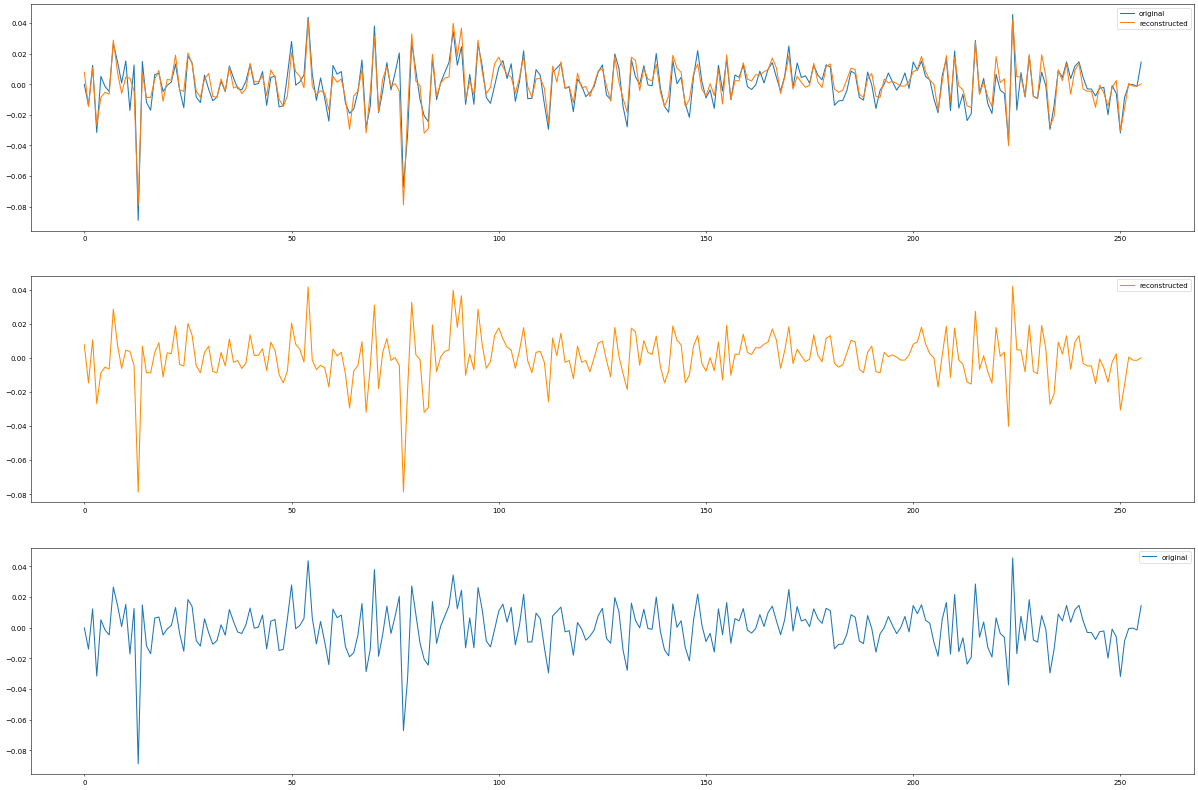

In [87]:
batch_idx = 0
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_conv2, data, extra_dim=True)

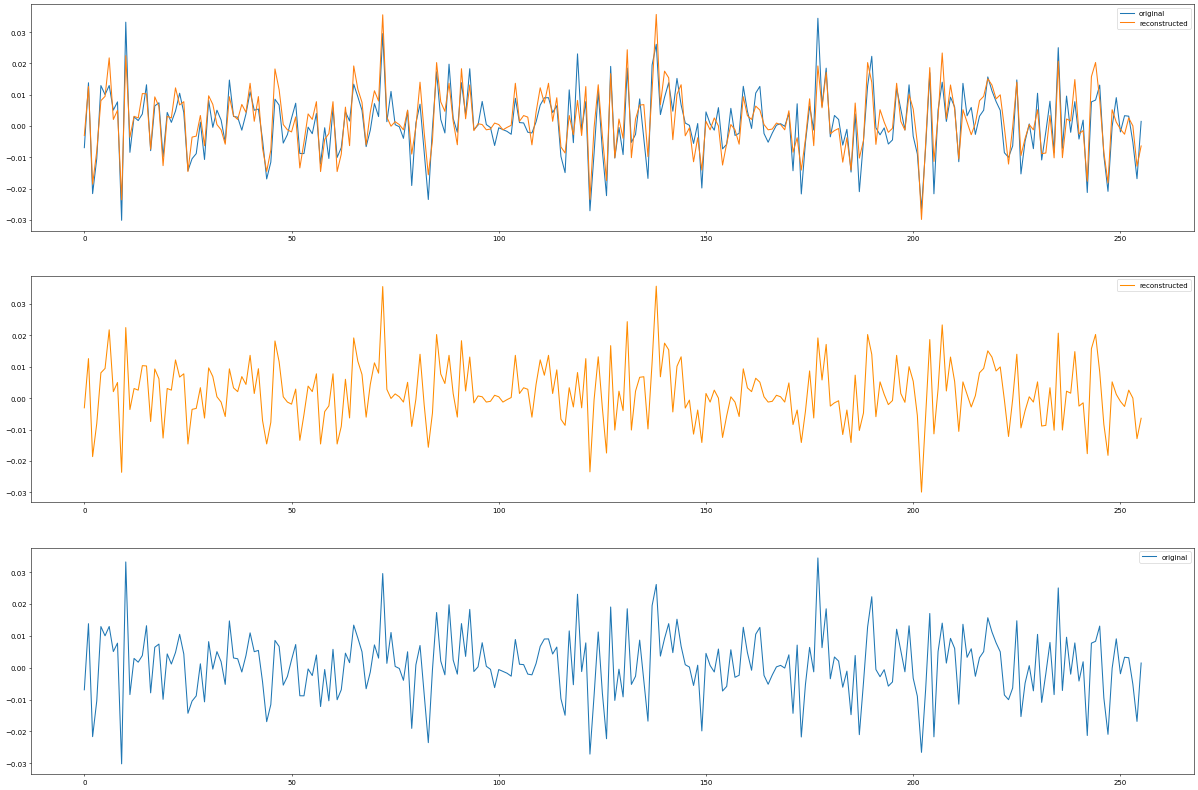

In [88]:
batch_idx = 40
series_idx = 2
x_hat=plot_reconstruction(batch_idx, series_idx, vq_vae_conv2, data, extra_dim=True)

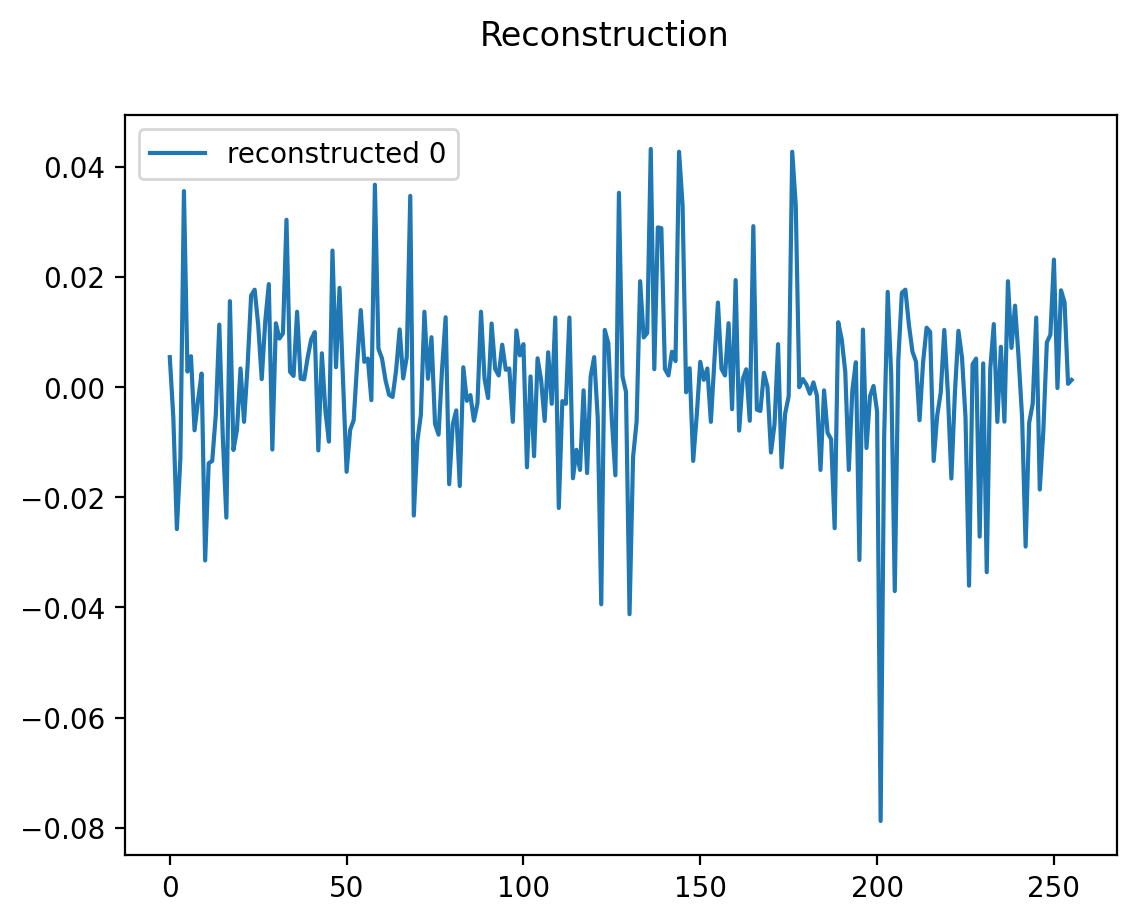

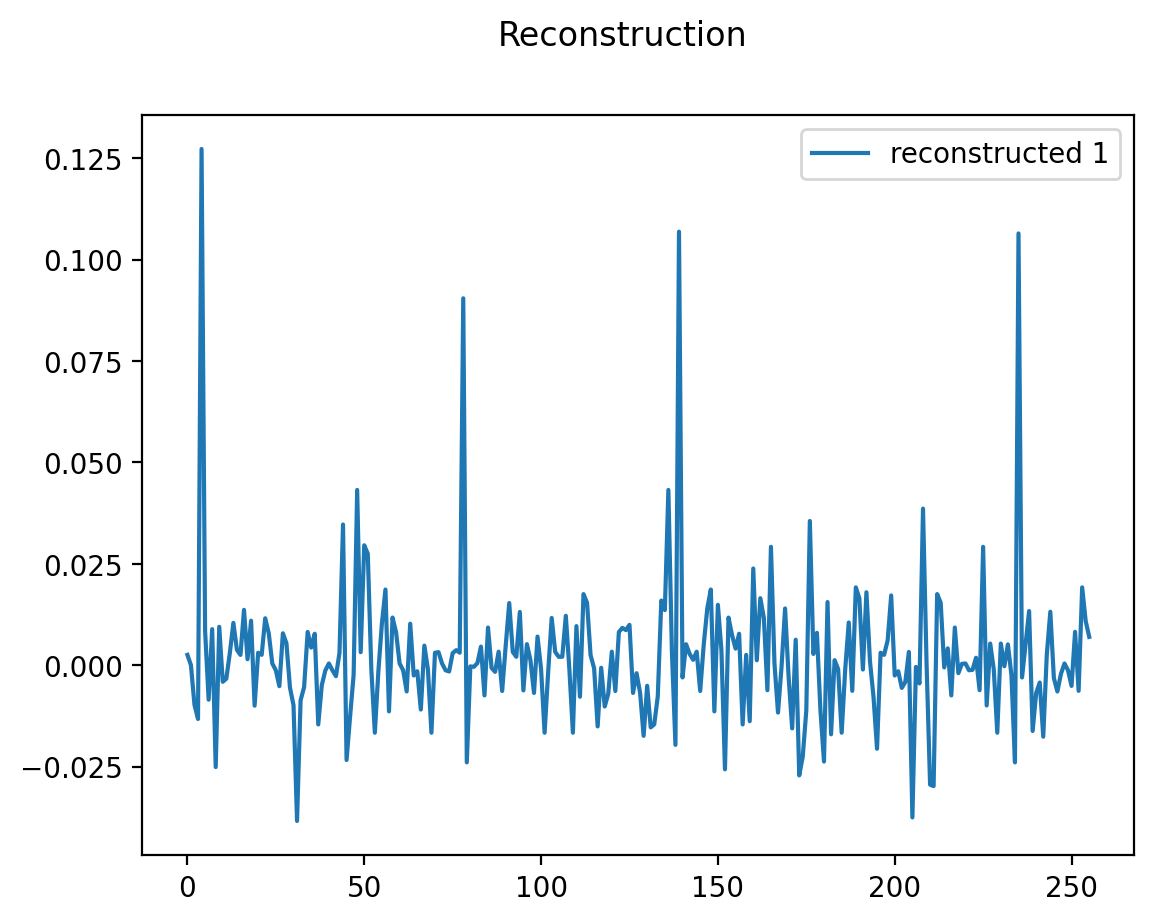

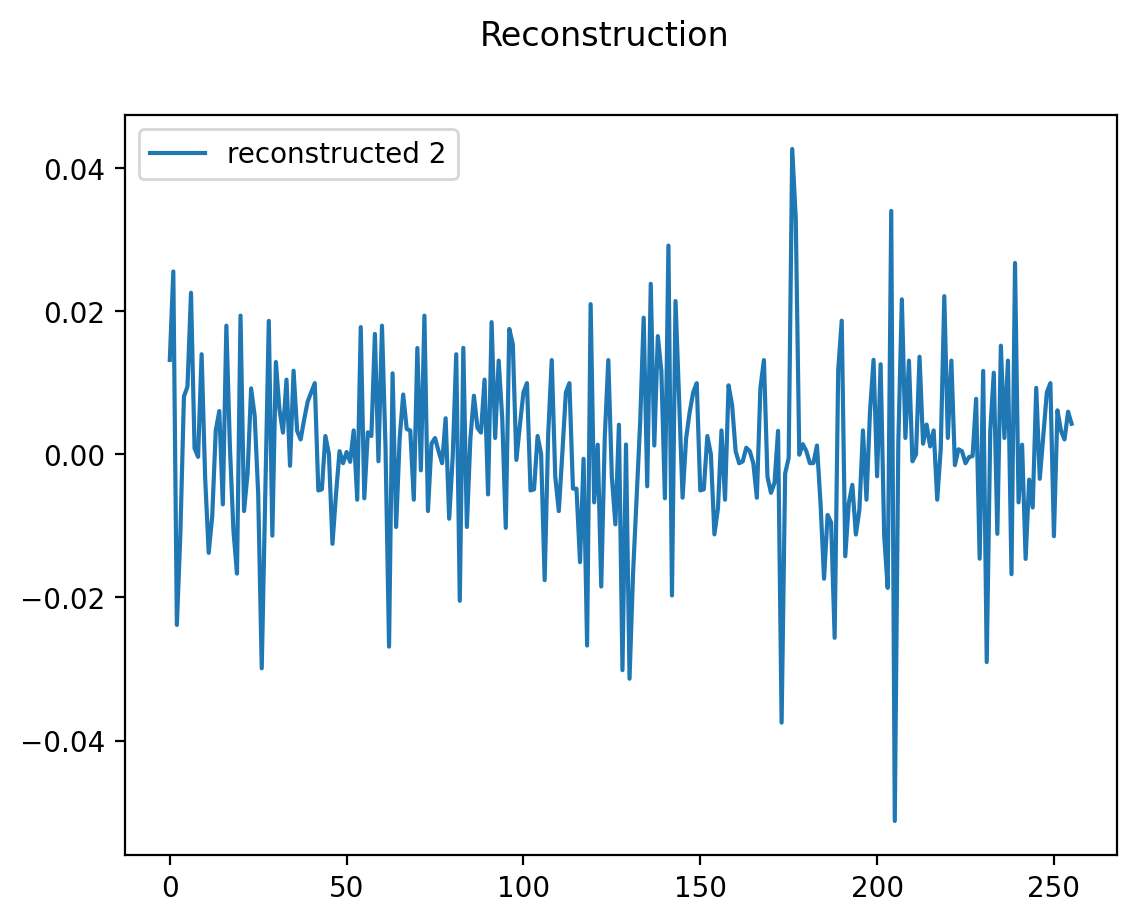

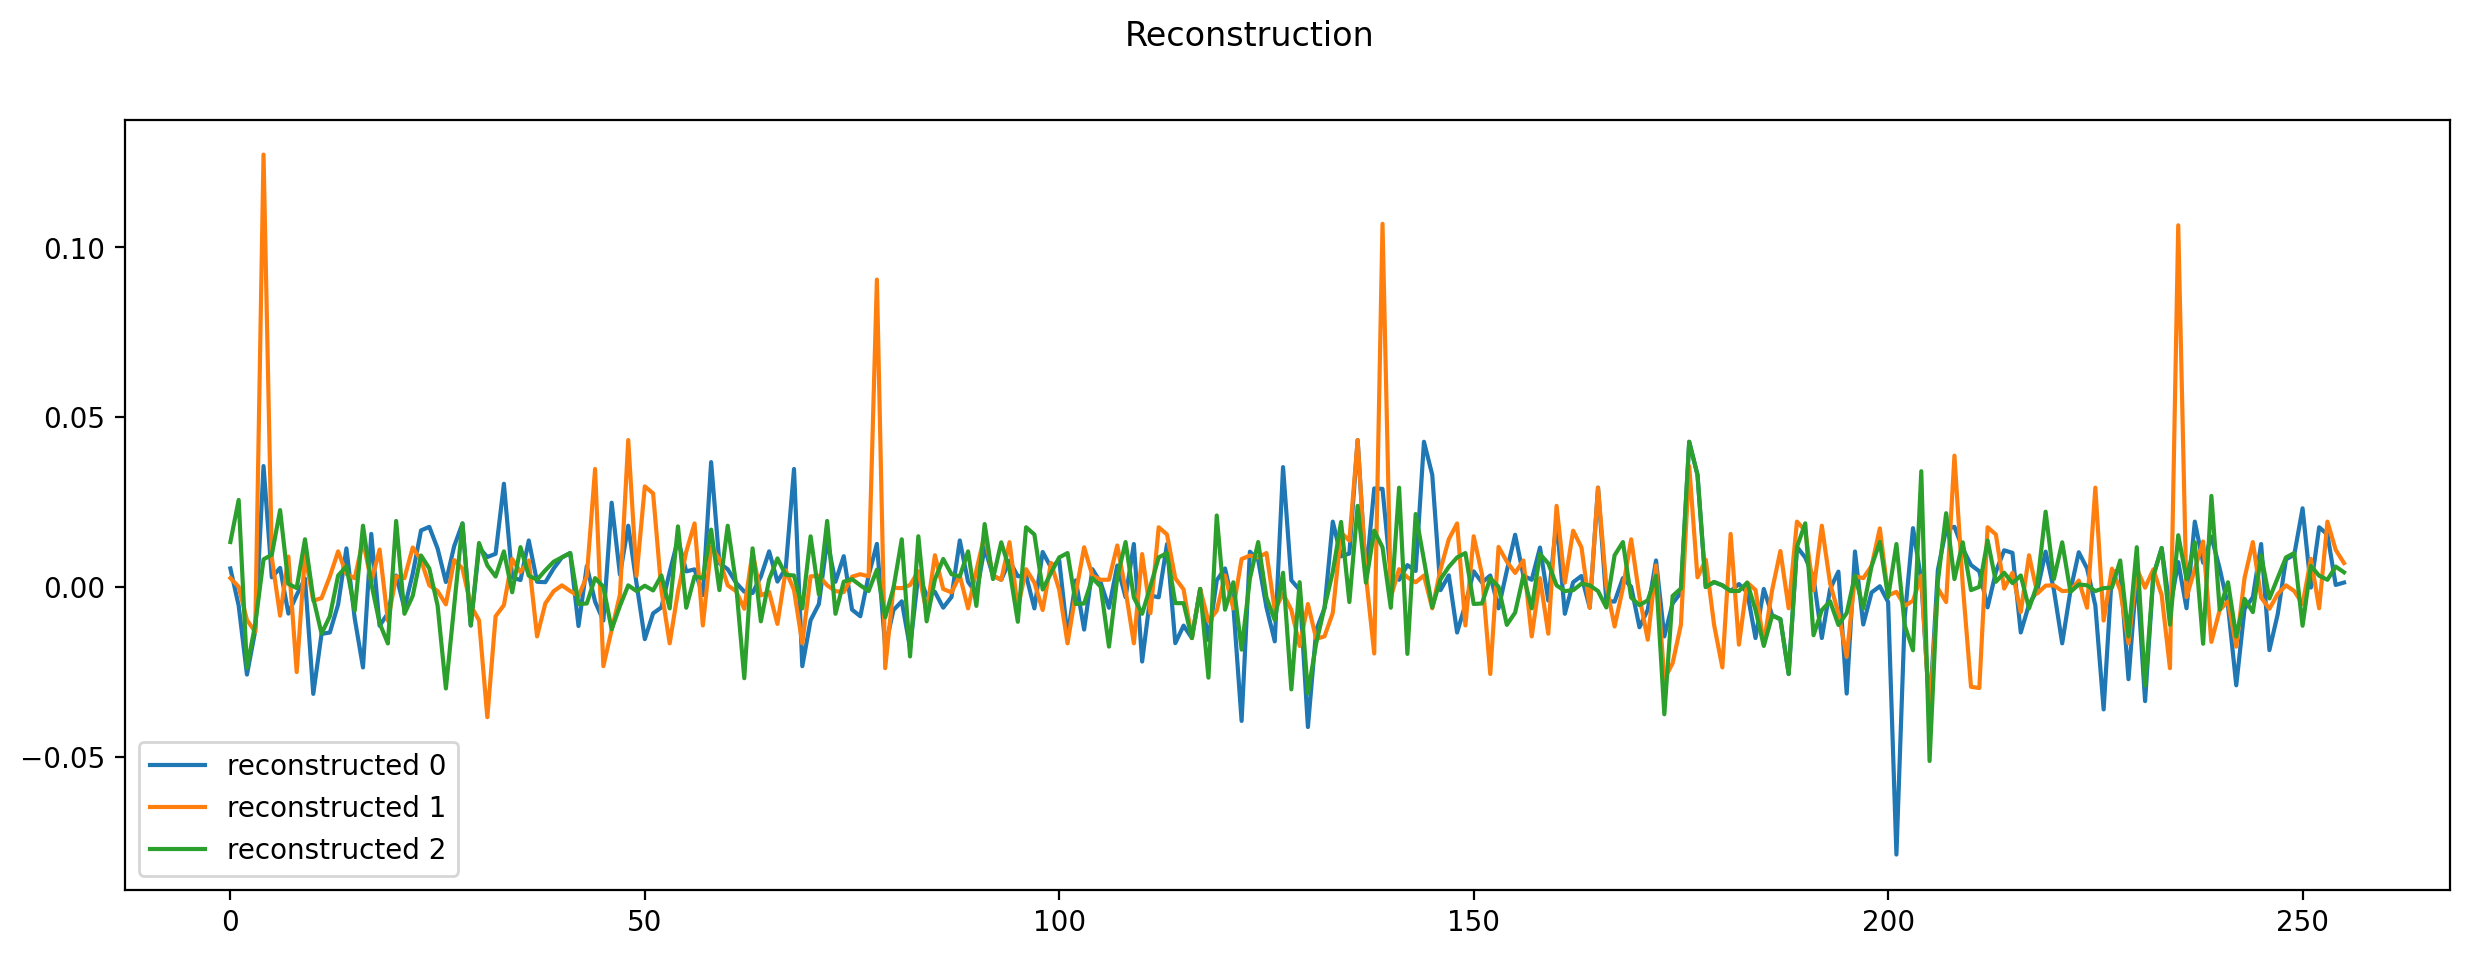

In [89]:
idxs = [20,50,110]
plot_series(x_hat, idxs, label = 'reconstructed ', title='Reconstruction', figsize=(15, 5), merge=True)

In [143]:
embedding_dim = 16
num_embeddings = 128
generation= vqvae_generation(vq_vae_conv2, data.copy(), embedding_dim, num_embeddings, extra_dim=True)
print(generation.shape)

(434, 256)


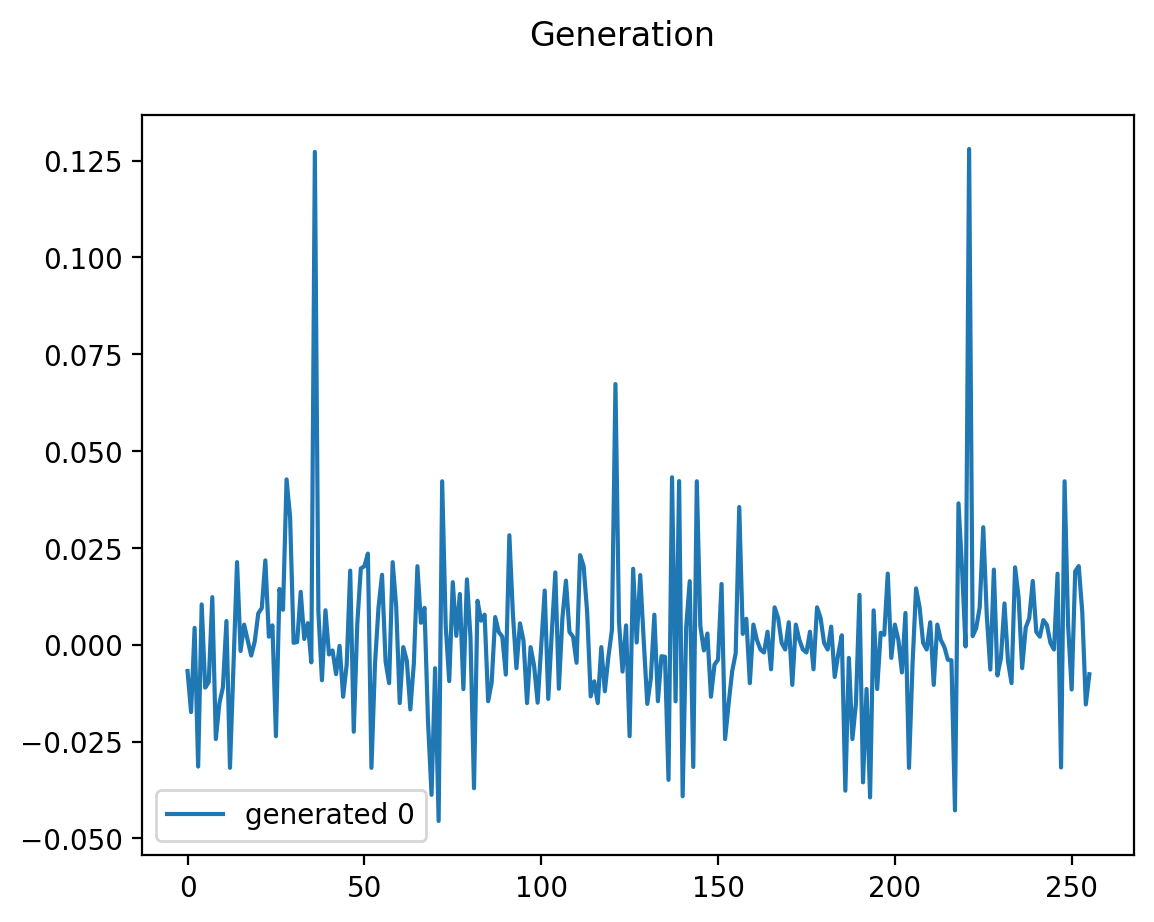

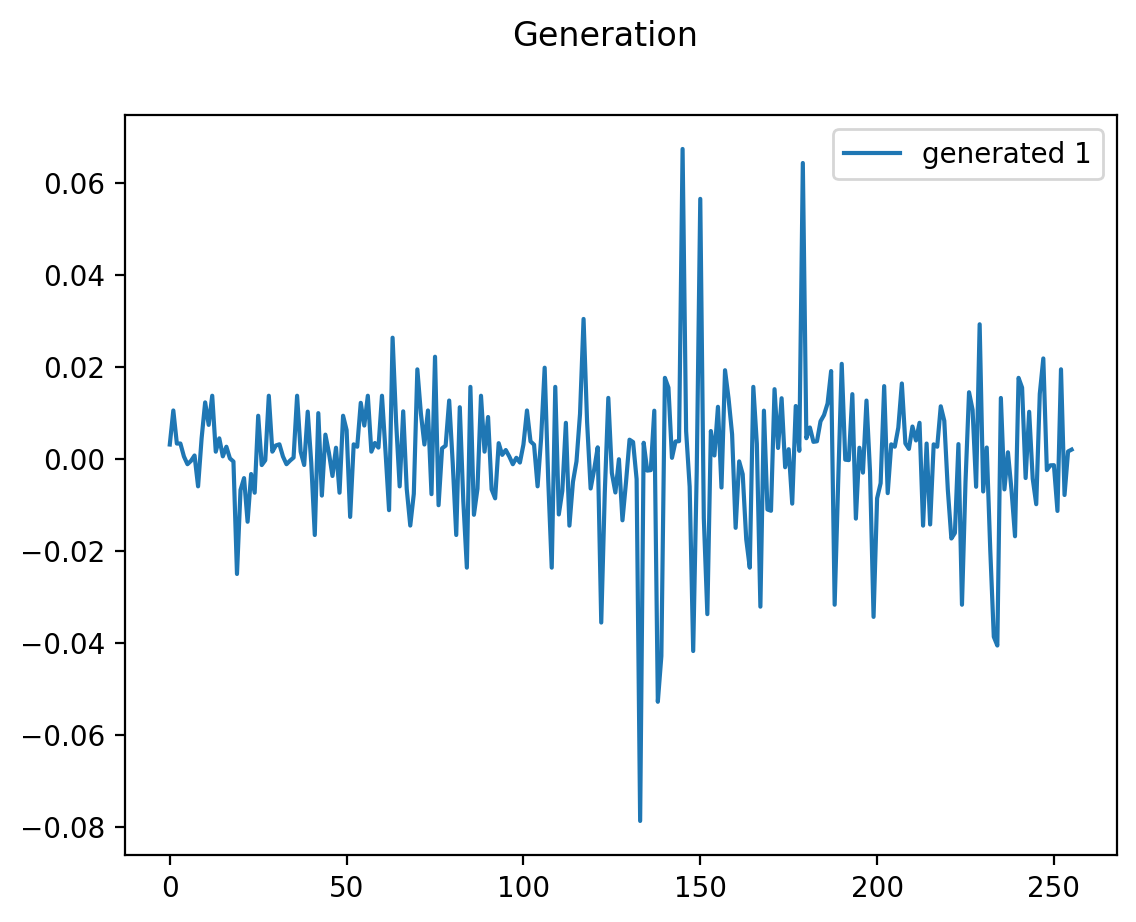

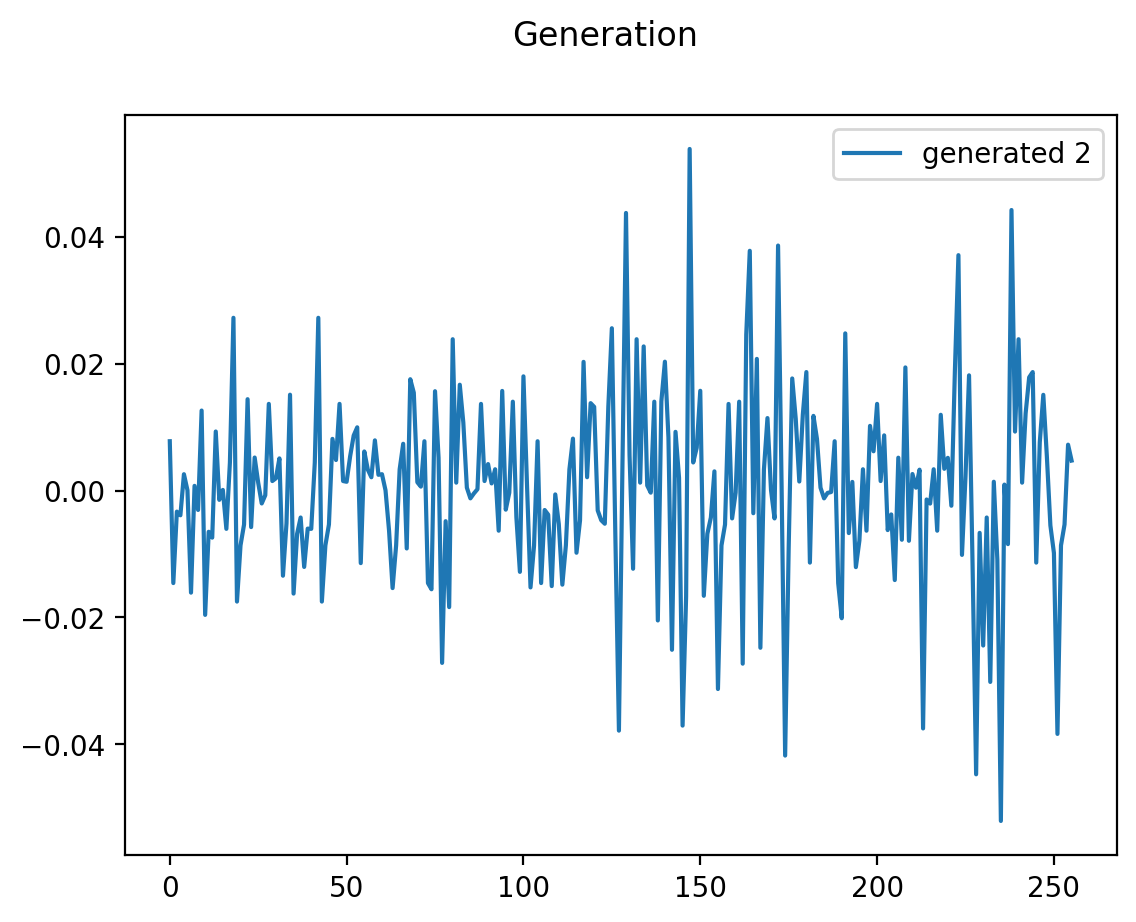

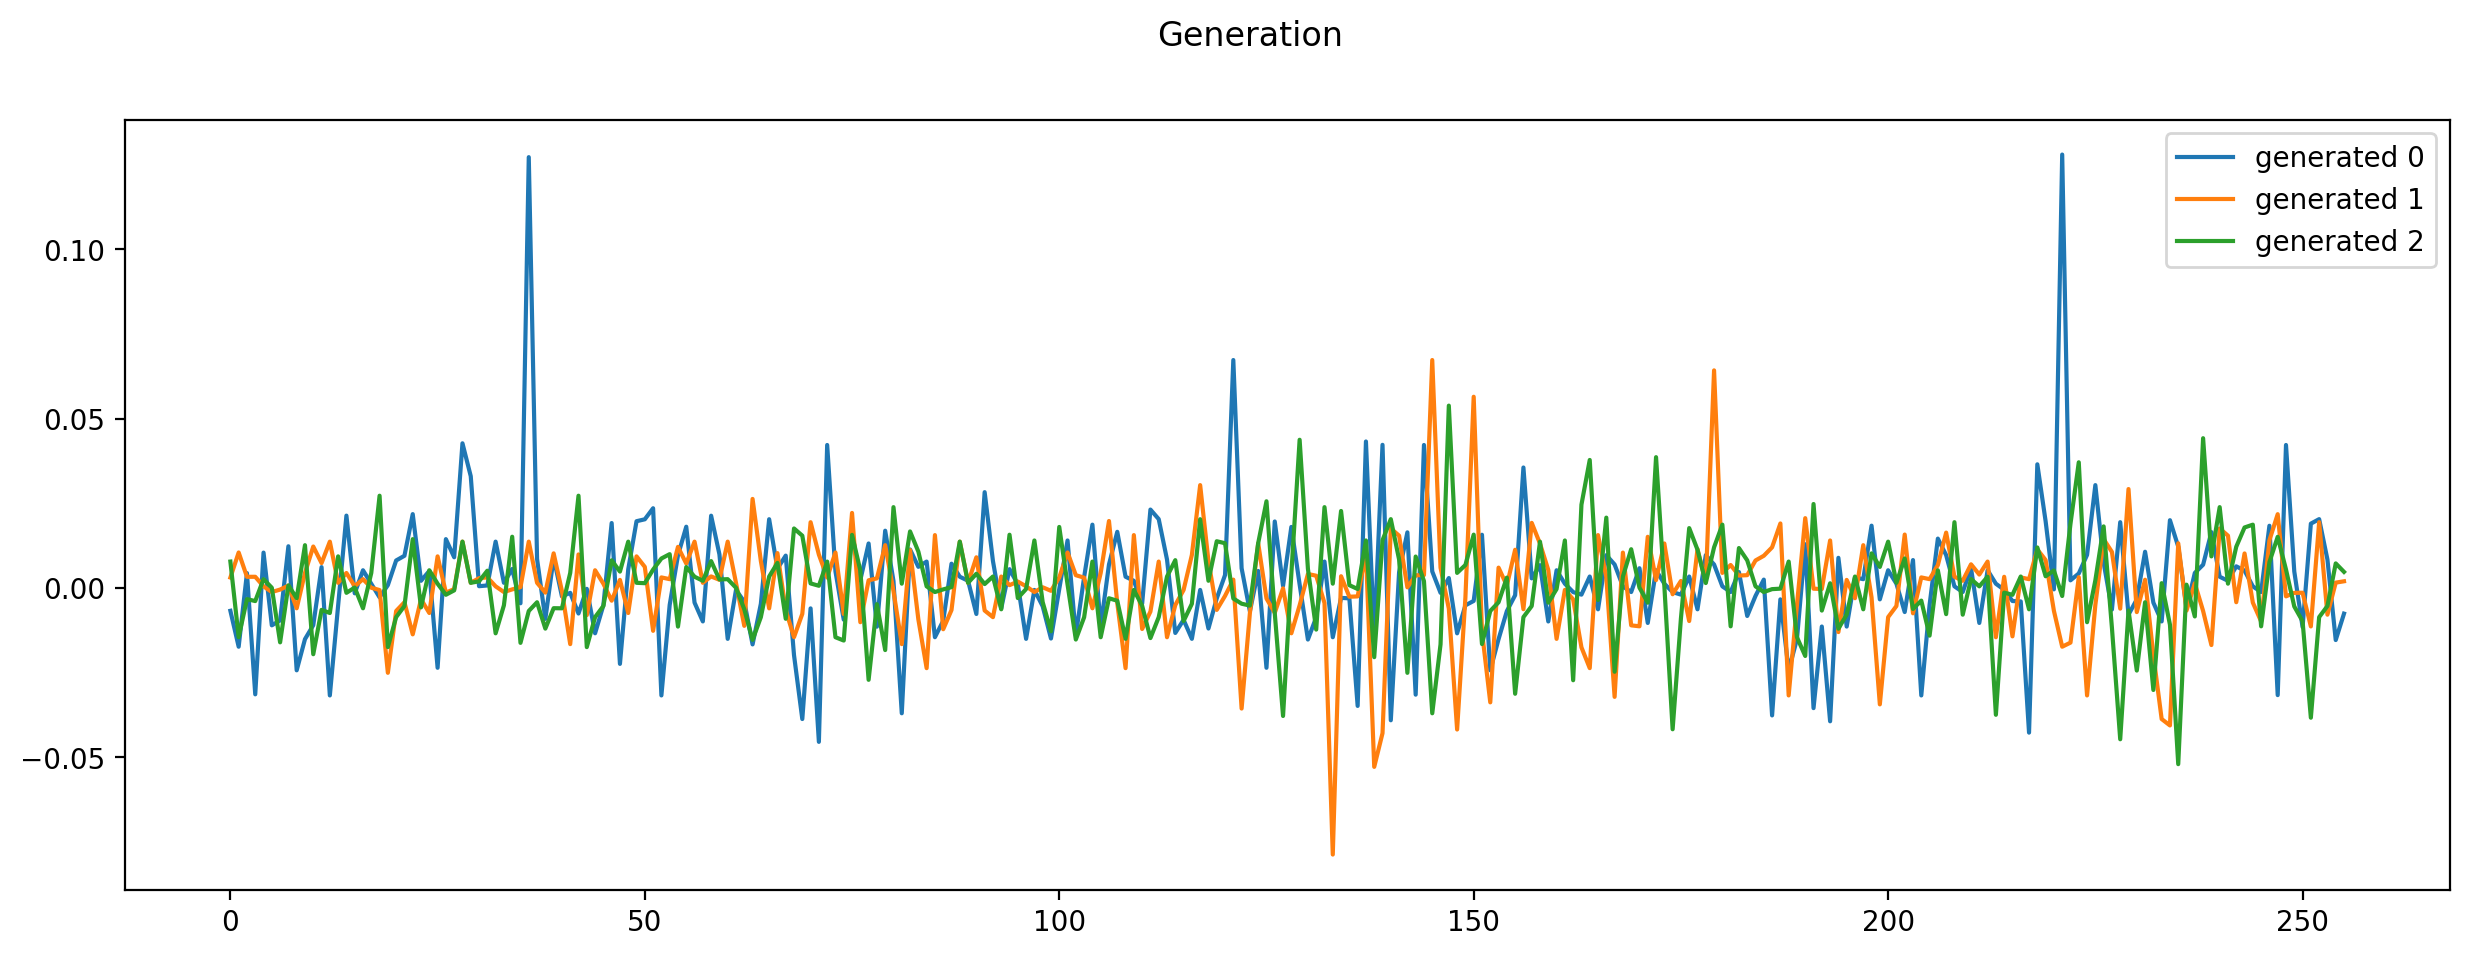

In [129]:
idx = [1, 2, 3]
plot_series(generation, idxs, label = 'generated ', title='Generation', figsize=(15, 5), merge=True)

In [130]:
np.save(gen_dir+'vqvaeconv2.npy',generation)
torch.save(vq_vae_conv2.state_dict(), models_dir +"vqvaeconv2.pth") 

In [164]:
encoding_indices_data = get_encode_indices(vq_vae_conv2, data.copy(), extra_dim=True)
encoding = pd.DataFrame(encoding_indices_data.to_numpy().flatten())
encoding.columns = ['encoding']
encoding_count =  encoding.value_counts()
encoding_index = encoding_count.index
encoding_index = np.array(encoding_index)
encoding_index.shape

(109,)

In [165]:
encoding_indices_data.shape

(34286, 64)

In [167]:
encoding_indices_data.duplicated().sum()

32

In [168]:
encoding_indices_data[encoding_indices_data.duplicated(keep=False)]

e0  e1  e2   e3   e4   e5   e6  e7   e8   e9  ...  e54  e55  e56  e57   
148     7  39  63    8   49  108   85  20   26  116  ...   80   29  125   90  \
167     7  39  63    8   49  108   85  20   26  116  ...   80   29  125   90   
582    77  55  76   95  108   13  118  70  104   13  ...    7  123   10   60   
601    77  55  76   95  108   13  118  70  104   13  ...    7  123   10   60   
1016   22  52  92   55  116   69   76  13  115   23  ...  116  113   77  120   
...    ..  ..  ..  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ...   
12753  13  17  70  108   20  113   50  34   63  118  ...   23   23   70   51   
13168  62   0  35   11  125   13   23  76   94   70  ...   11   70   55   23   
13187  62   0  35   11  125   13   23  76   94   70  ...   11   70   55   23   
13602  69  70  69   32   52  104  114  34   87   96  ...   36   73   28   96   
13621  69  70  69   32   52  104  114  34   87   96  ...   36   73   28   96   

       e58  e59  e60  e61  e62  e63  
148     49   42   92  113  101   94  
167     49   42   92  113  101   94  
582     91   87   94   63   36   94  
601     91   87   94   63   36   94  
1016    90  115  118   97  116  116  
...    ...  ...  ...  ...  ...  ...  
12753  104   11   23   11   32   22  
13168   22   87   62   51  120   55  
13187   22   87   62   51  120   55  
13602  115   22   70   22   70   94  
13621  115   22   70   22   70   94  

[64 rows x 64 columns]

In [169]:
encoding_sampled = sampling_to_quantize(encoding_indices_data, stocks)
encoding_sampled.shape

torch.Size([434, 64, 1])

In [170]:
encoding_sampled = encoding_sampled.squeeze()
encoding_sampled = pd.DataFrame(encoding_sampled)
encoding_sampled.shape

(434, 64)

In [171]:
encoding_sampled.duplicated().sum()

0

In [173]:
encoding_sampled.columns = encoding_indices_data.columns

In [174]:
encoding_sampled.shape

(434, 64)

In [175]:
encoding_indices_data.shape

(34286, 64)

In [178]:
encoding_sampled.head()

e0   e1  e2   e3  e4   e5   e6  e7   e8  e9  ...  e55  e56  e57  e58  e59   
0  113   85  70   23  32   13  104  33  114  62  ...   92  115   23   62   93  \
1   36   87  94   95  75   30   80  62   62  17  ...  116   93   95   48  115   
2    7   20  13   64  69  124   96   0   12  81  ...   82   94   35   62   19   
3   22   34  34   87  67   36   23  52   76  85  ...   69  118   85  118  104   
4   85  113  81  120  17  108   22  28   79  98  ...   23  104   51   34  115   

   e60  e61  e62  e63  sampled  
0   62  118   70   53     True  
1   46   85   48  121     True  
2   81  113   85   70     True  
3   69   35  118   22     True  
4  102   76   99   76     True  

[5 rows x 65 columns]

In [179]:
encoding_indices_data.head()

e0  e1   e2   e3  e4  e5   e6   e7  e8   e9  ...  e55  e56  e57  e58  e59   
0  88  56   15   81  15   1    1   75  26  116  ...   29   12   28   88   15  \
1   7  51   60  108  70  70  114  102  22   90  ...   69    8   90  123   55   
2  76   8  116   88  20  51  102   20  20  104  ...   36   81   90   82  115   
3  53   8   32   34  96  62   20   69  51   35  ...   34   18   35   82  115   
4  46  53  116   60  77  35   62   20  13   87  ...    7   18   23   82   55   

   e60  e61  e62  e63  sampled  
0   92  120   47   24    False  
1   90    7   36   76    False  
2   23  113  101   70    False  
3   70   95   64   70    False  
4   18   64   36   62    False  

[5 rows x 65 columns]

In [180]:
encoding_sampled['sampled'] = True
encoding_indices_data['sampled'] = False
all_data = pd.concat([encoding_sampled, encoding_indices_data], ignore_index=True, axis=0)
all_data.shape

(34720, 65)

In [187]:
duplicates = all_data[all_data.duplicated(keep=False)]
duplicates.groupby(['sampled']).size()

sampled
False    64
dtype: int64

In [188]:
duplicates.shape


(64, 65)

In [147]:
pd.DataFrame(encoding_indices_data.to_numpy()).to_csv(gen_dir+'encoding_indices_data.csv', index=False)

## Exploring the model 

In [133]:
index = 3
batch= get_batch(data, index, shuffle_stocks=True ,extra_dim=True)
sample =  np.expand_dims(batch[0],axis=0)
print(sample.shape)
x = torch.from_numpy(sample)
print('input shape',x.shape)
vq_vae_conv2.eval()
z = vq_vae_conv2.encoder(x)
z = z.detach().cpu().numpy()
z = np.squeeze(z)
print('encode shape',z.shape)
x_recon, loss, perplexity, encodings, encoding_indices, quantized  = vq_vae_conv2(x)
encodings= encodings.detach().cpu().numpy()
encodings = np.squeeze(encodings)
print('output shape' ,x_recon.shape)
print('encoding_indices shape' ,encoding_indices.shape)
print('encodings shape' ,encodings.shape)
embeddings =vq_vae_conv2._vq_vae._embedding 
embeddings = embeddings.weight.detach().cpu().numpy()
print('embeddigs',embeddings.shape)
quantized = quantized.detach().cpu().numpy()
quantized = np.squeeze(quantized)
print('quantized shape',quantized.shape)


(1, 1, 256)
input shape torch.Size([1, 1, 256])
encode shape (16, 64)
output shape torch.Size([1, 1, 256])
encoding_indices shape torch.Size([1, 64])
encodings shape (64, 128)
embeddigs (128, 16)
quantized shape (16, 64)


Embeddings dim latent dim X Num embeddings : (128, 16)


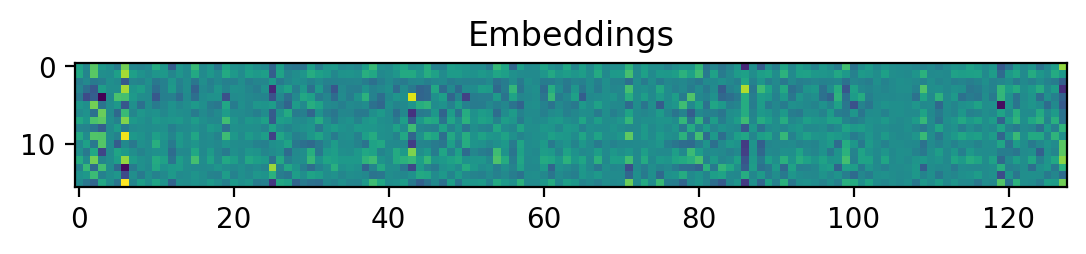

In [134]:
plt.imshow(embeddings.T)
plt.title("Embeddings")
print(f'Embeddings dim latent dim X Num embeddings : {embeddings.shape}')
plt.show()

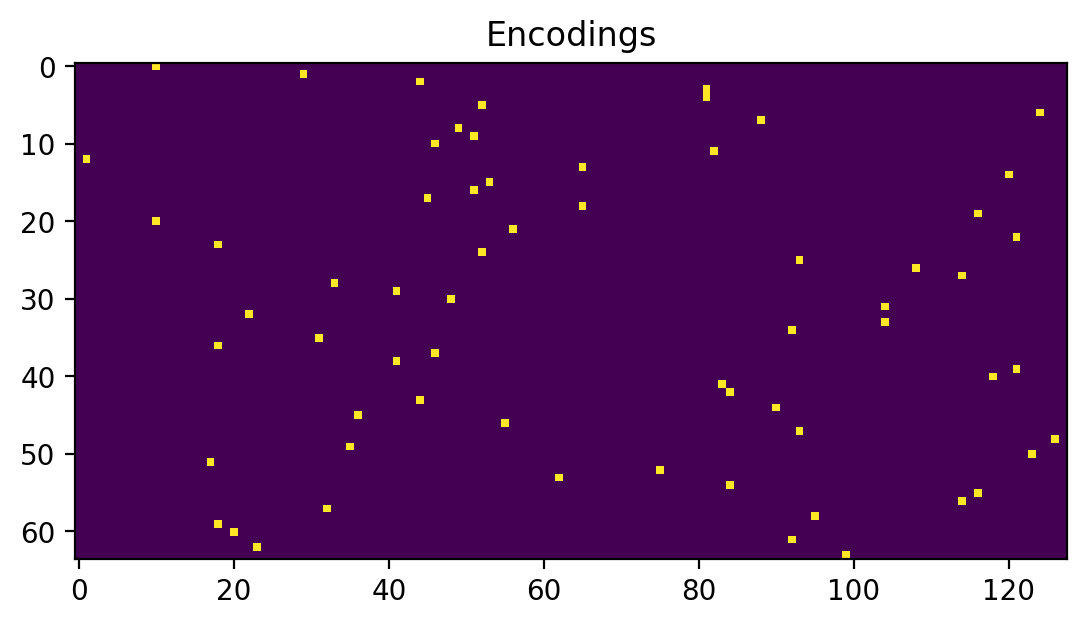

Encodings dim #vectors X Num embeddings : (64, 128)


In [135]:
plt.imshow(encodings)
plt.title("Encodings")
plt.show()
print(f'Encodings dim #vectors X Num embeddings : {encodings.shape}')

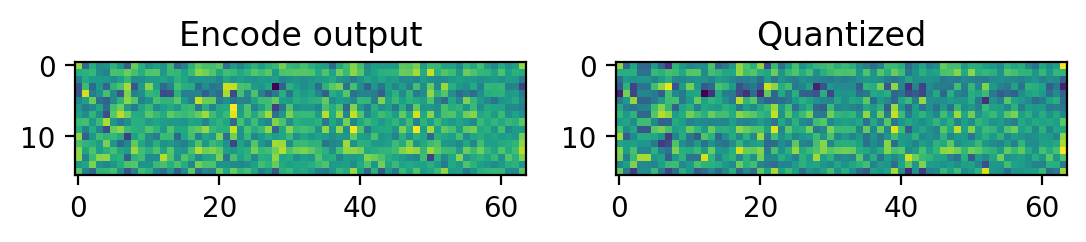

Encode output dim: (16, 64)
Quantized dim: (16, 64)


In [136]:
plt.subplot(1, 2, 1)
plt.imshow(z)
plt.title("Encode output")
# plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(quantized)
plt.title("Quantized")
# plt.axis("off")
plt.show()

print(f'Encode output dim: {z.shape}')
print(f'Quantized dim: {quantized.shape}')